In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import matplotlib.cm as cm
import time,os,subprocess
import copy
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
from math import radians, sin, cos, sqrt, asin
import scipy.interpolate as interpolate
import pyart.graph.cm as pcm
import cPickle as pickle
import datetime
import pyproj
import scipy.ndimage as ndi
import mahotas,pymorph,pylab
import pims
import trackpy as tp
from PIL import Image
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level,haversine
%matplotlib inline

## Tracking KDP/ZDR columns in Houston NEXRAD data using TrackPy
We will follow on the techniques used in kdp_cell_tracker.ipynb, with the following innovations:
- We will use KDP and ZDR "potential energy" which is $K_{DP}*h $, where h is height
- We now use new version of trackpy (maybe this is a pain in the ass)
- We are older and wiser nowaday

The motivation behind KDP and ZDR "potential energy" is as follows: we are concerned not only with the height of KDP/ZDR columns, but with the values of KDP/ZDR within them (and maybe this is more true for KDP than ZDR). 

## What's new:
This code was split from the original on May 5 2017 so as to simplify and beautify the tracking code and make it more modular and easier to use. YMMV. 

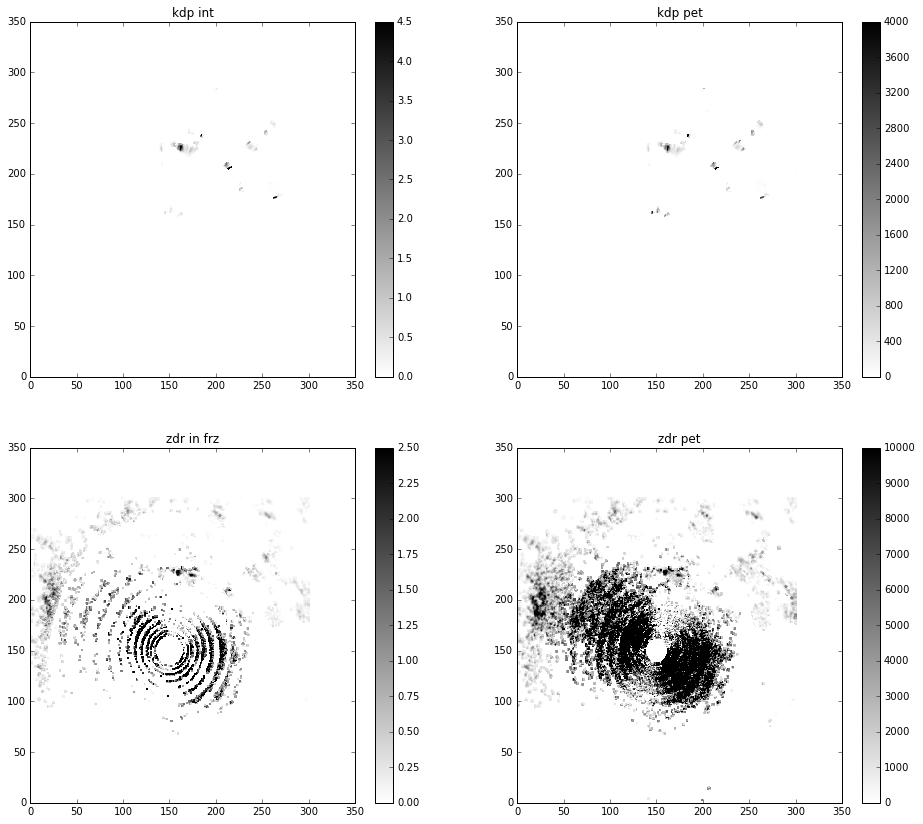

In [3]:
#..First let's consider *how* exactly we will identify these objects. We will attempt to use "KDP potential energy"
#..to identify these features. Let us start by looking at a single, suggestive time from KHGX
#filenm = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid02_khgx_20130608_202447.nc'
#filenm = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid01_khgx_20130608_202447.nc'
filenm = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/grid01_khgx_20130619_210307.nc'
#filenm = '/home/mvanlier/mvanlier/nexrad_khgx/20130722/grid00_khgx_20130722_172959.nc'
khgx_lat = 29.468
khgx_lon = -95.075
radr_lat = khgx_lat
radr_lon = khgx_lon

zsfc = 35.   #..m (= 115 feet)
nc = Dataset(filenm,'r')
xd = nc.variables['x_disp'][:]
yd = nc.variables['y_disp'][:]
zd = nc.variables['z_disp'][:]
#..Make vectors of cell edges
xe = make_edge_vec(xd)
ye = make_edge_vec(yd)
ze = make_edge_vec(zd)
alt= zd + zsfc
alte=ze + zsfc
zhh = nc.variables['reflectivity'][0,:,:,:]
zdr = nc.variables['differential_reflectivity'][0,:,:,:]
kdp = nc.variables['kdp'][0,:,:,:]
rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
nc.close()

#..Get lat/lon from dx,dy
lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
#..
zgrid = np.zeros((len(zd),len(yd),len(xd)))
for j in range(len(zd)):
    zgrid[j,:,:] = zd[j]

#..
zdr_proc = copy.deepcopy(zdr)
zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
kdp_proc = copy.deepcopy(kdp)
kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
#kdp_proc = np.ma.masked_where(zhh<20.,kdp_proc)
kdp_int = kdp_proc[9:15,:,:].sum(axis=0)

vol_ones = zdr_proc*0.+1
kdp_pe = kdp_proc*zgrid
zdr_pe = zdr_proc*zgrid
kdp_pet = kdp_pe[9:17,:,:].sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)
zdr_pet = zdr_pe[9:17,:,:].sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)


#..Plot
fig = plt.figure(figsize=(16,14))
ax = fig.add_subplot(221)
aa = ax.pcolormesh(kdp_int[50:351,50:351],cmap=cm.gray_r,vmin=0,vmax=4.5)
plt.title('kdp int')
plt.colorbar(aa)
ax = fig.add_subplot(222)
ab = ax.pcolormesh(kdp_pet[50:351,50:351],cmap=cm.gray_r,vmin=0,vmax=4000.)
plt.colorbar(ab)
plt.title('kdp pet')
ax = fig.add_subplot(223)
ba = ax.pcolormesh(zdr[11,50:351,50:351],cmap=cm.gray_r,vmin=0.,vmax=2.5)
plt.colorbar(ba)
plt.title('zdr in frz')
ax = fig.add_subplot(224)
bb = ax.pcolormesh(zdr_pet[50:351,50:351],cmap=cm.gray_r,vmin=0.,vmax=10000)
plt.colorbar(bb)
plt.title('zdr pet')
#..

In [4]:
def normalize_array(array_in,minval=0,maxval=255,integerout=True,invert=False):
    array_out = copy.deepcopy(array_in)
    array_out[array_out<0.] = 0.  #..Here is subzero, now plain zero
    #..we lazily assume the minimum is zero...
    array_out = maxval*array_out/(array_out.max())
    if integerout:
        array_out = array_out.astype(np.uint8)
    if invert:
        array_out = maxval-array_out
    return array_out

### Moving on to implementation of feature ID and tracking
We will go forward with kdp_pe, even though it does not seem to offer an obvious advantage over kdp_int. We make this choice because this metric makes *more sense*. The main thing is getting trackpy to read it. 

The way to do this is: load and processing data as numpy arrays, save in a temp file as tiff images, use trackpy to load tiff and track tiff images. Then use the tracks from trackpy with numpy arrays to do all the analysis. 

### First, process files into TIFF images of "KDP potential energy"

In [5]:
#..Get a list of radar data files. 
nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/'
#nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/'
#nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130722/'
#radfile_start = 'grid00_khgx'
#radfile_start = 'grid01_khgx'
radfile_start = 'grid01_khgx'
numfiles = 0
radfiles = []
for root,dirs,files in walklevel(nexrad_path,level=0):
    for file in files:
        if file.startswith(radfile_start):
            radfiles.append(file)
            numfiles += 1
#print radfiles
radfiles = sorted(radfiles)
filenm = radfiles[0]

#..Load up things that don't change file-by-file
filenm = nexrad_path+radfiles[0]
nc = Dataset(filenm,'r')
xd = nc.variables['x_disp'][:]
yd = nc.variables['y_disp'][:]
zd = nc.variables['z_disp'][:]
#..Make vectors of cell edges
xe = make_edge_vec(xd)
ye = make_edge_vec(yd)
ze = make_edge_vec(zd)
alt= zd + zsfc
alte=ze + zsfc
#..Get lat/lon from dx,dy
lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
#..
zgrid = np.zeros((len(zd),len(yd),len(xd)))
for j in range(len(zd)):
    zgrid[j,:,:] = zd[j]
nc.close()

#..Loop and load and analyze radar data to get kdp potential energy
for i in xrange(numfiles):
    filenm =nexrad_path+radfiles[i]
    nc = Dataset(filenm,'r')
    zhh = nc.variables['reflectivity'][0,:,:,:]
    zdr = nc.variables['differential_reflectivity'][0,:,:,:]
    kdp = nc.variables['kdp'][0,:,:,:]
    rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
    nc.close()

    kdp_proc = copy.deepcopy(kdp)
    kdp_proc[rho<.8] = 0.
    kdp_proc[zhh<15.] = 0.
    kdp_proc[kdp_proc==-9999.] = 0.
    #kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
    #kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
    #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
    #kdp_proc = np.ma.masked_where(zhh<20.,kdp_proc)
    #kdp_int = kdp_proc[9:15,:,:].sum(axis=0)

    vol_ones = kdp_proc*0.+1
    kdp_pet = (zgrid[9:17,:,:]*kdp_proc[9:17,:,:]).sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)
    kdp_pet[kdp_pet>3000.]=3000.

    kdp_pet_proc = normalize_array(kdp_pet,invert=True)
    
    #..
    img = Image.fromarray(kdp_pet_proc)
    img.save(nexrad_path+'temp_20130619_00/kdp_pe_'+str(i).zfill(3)+'.tiff')

### Now load one of these images to fine-tune detection

In [6]:
frames = pims.ImageSequence(nexrad_path+'temp_20130619_00/*.tiff', as_grey=True)
#framesa = pims.ImageSequence('temp4/*.tiff', as_grey=True)
#..

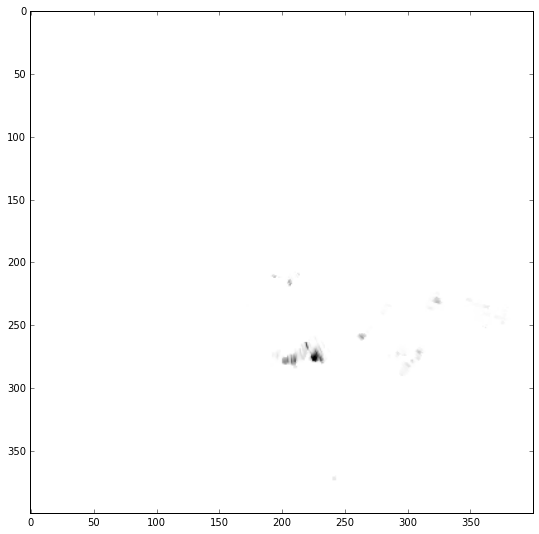

In [8]:
plt.figure(figsize=(10,9))
plt.imshow(frames[78],cmap=cm.gray)
#plt.imshow(frames[87]-framesa[87],cmap=cm.gray)
#..

In [9]:
f = tp.locate(frames[78], 11, invert=True)

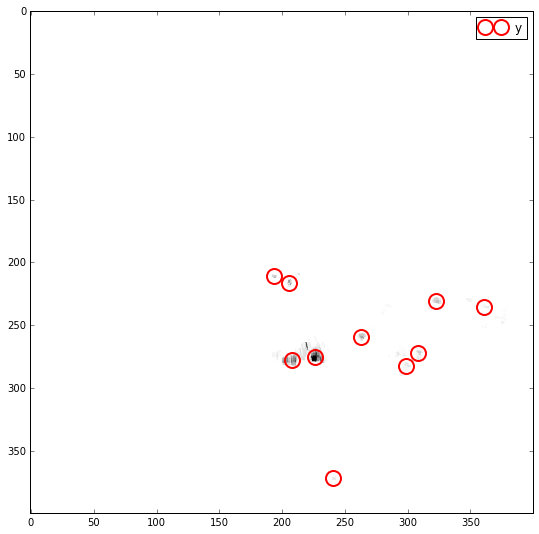

In [11]:
plt.figure(figsize=(10,9))  # make a new figure
tp.annotate(f, frames[78])

In [12]:
#..Locate features in all frames
f = tp.batch(frames[:], 11, invert=True)

Frame 133: 0 features


In [13]:
# 9 is about 30m/s
#..Link features into trajectories
t = tp.link_df(f, 9, memory=2)

Frame 131: 2 trajectories present


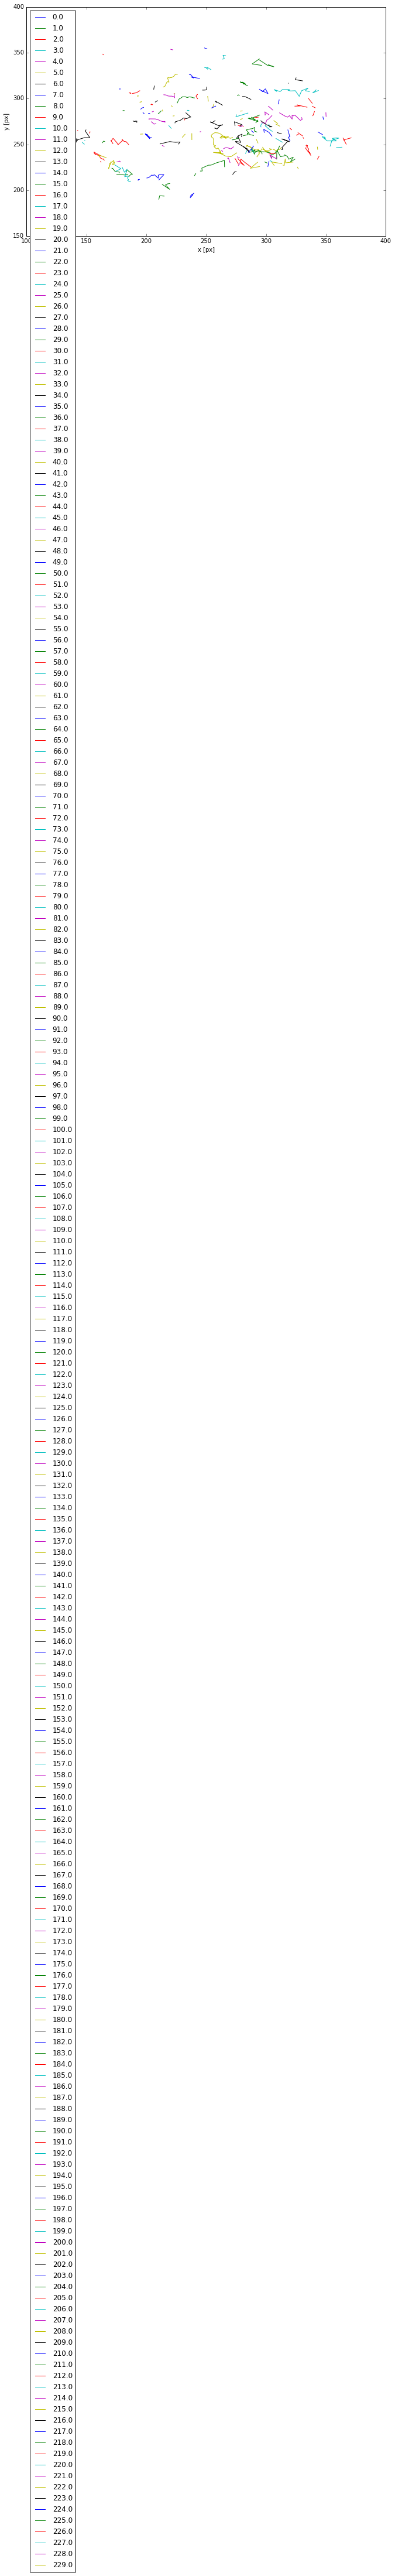

In [14]:
fig = plt.figure(figsize=(11,7))
#ax=fig.add_subplot(111)
ax = tp.plot_traj(t)
#ax = plt.gca()
ax.legend_.remove()
#ax.legend_ = None
#draw()

In [15]:
t1 = tp.filter_stubs(t, 4)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

('Before:', 230)
('After:', 85)


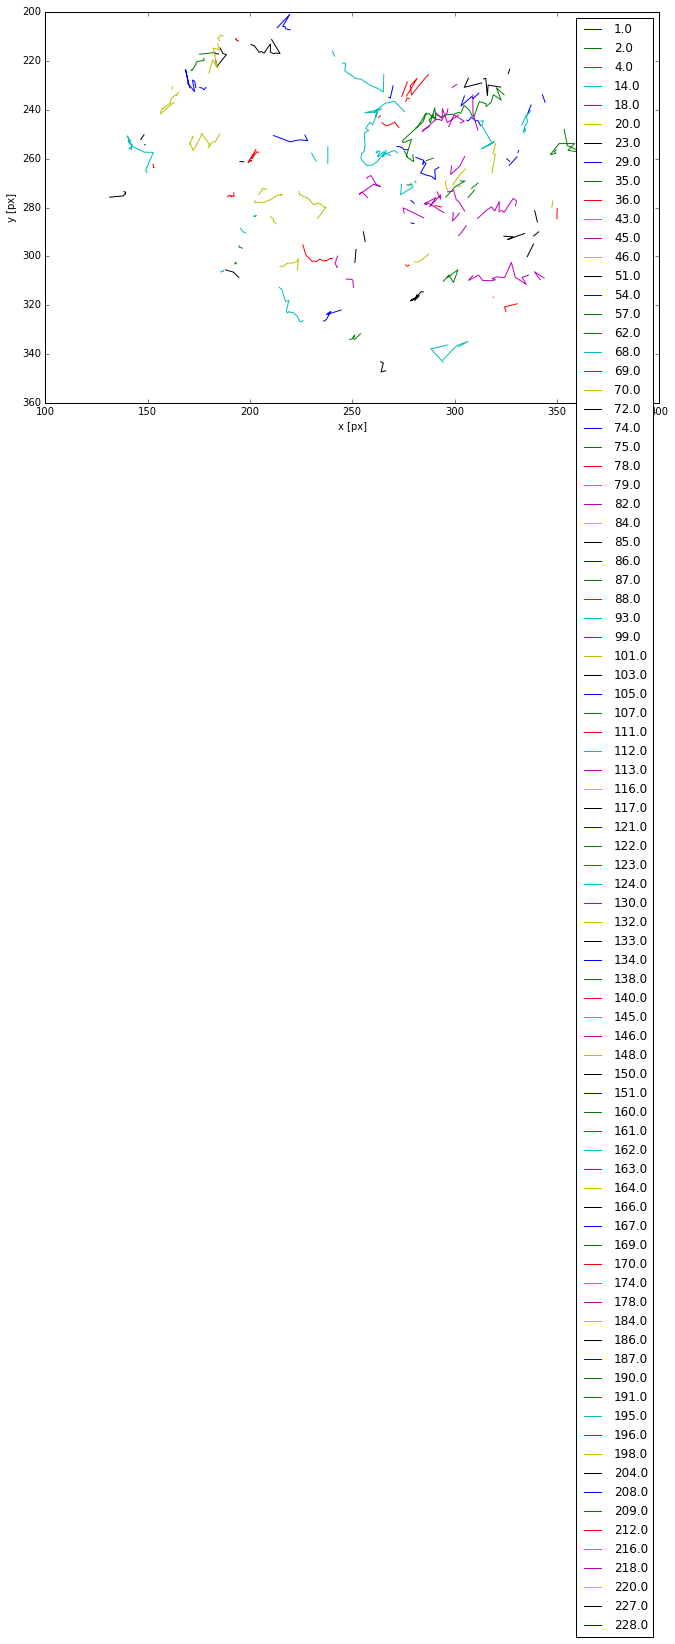

In [16]:
fig = plt.figure(figsize=(11,7))
#ax=fig.add_subplot(111)
ax = tp.plot_traj(t1)

### Try fancy predictive tracking

In [18]:
import trackpy.predict

In [19]:
#..Track with prediction?
pred = trackpy.predict.NearestVelocityPredict()
t = pred.link_df(f, 9, memory=3)
#t = pred.link_df(f, 16, memory=2)

Frame 131: 2 trajectories present


In [20]:
t1 = tp.filter_stubs(t, 6)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

('Before:', 277)
('After:', 50)


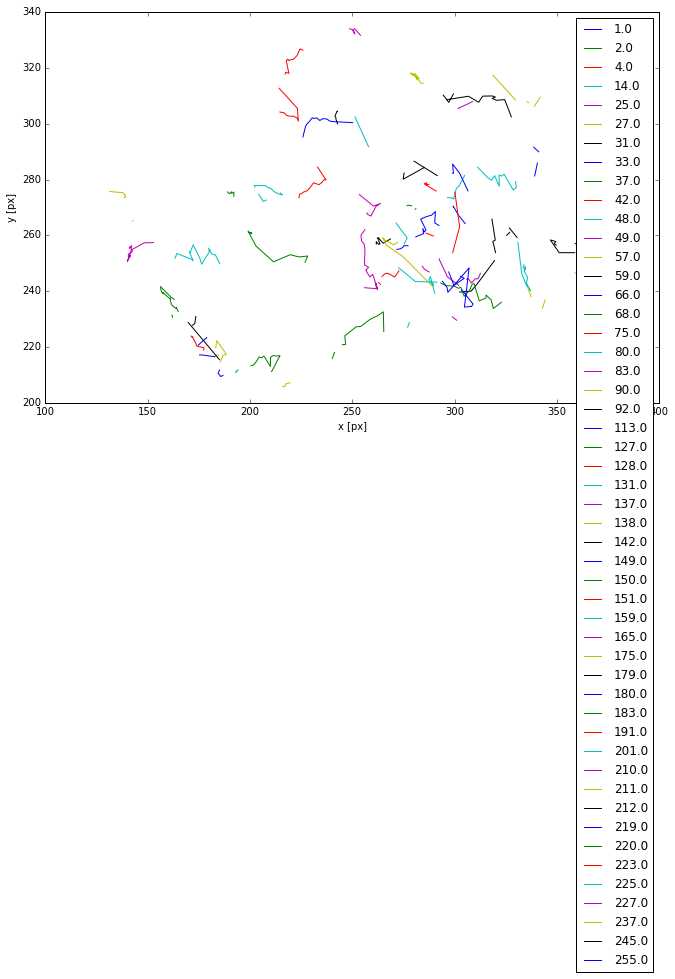

In [21]:

fig = plt.figure(figsize=(11,7))
#ax=fig.add_subplot(111)
ax = tp.plot_traj(t1)

## Code that loops over trajectories, analyzes and plots is shown below!
This is an amalgamem of code from plot_houston_lma and kdp_cell_tracker. At some point I may integrate an automatic html generator from html_mc3e_stratiform, to automate the generation of html files for animation. We will see!

In [46]:
def plot_track_follow(t1,nexrad_path, partnum, lmapath=None, dsdpath=None, dist_to_khgx_thresh=120000., 
                      mask_rhothresh=0.8,
                      mask_dbzthresh=15., distradius=5000., distradius_d=5000., kdpthr=0.5, zdrthr=0.75,
                      radfile_start='grid02_khgx',dsdfile_start='grid_dsd_KHGX',rrafile_start='grid_rra_KHGX',
                      xbuff=5000., ybuff=5000.,opath='/home/mvanlier/mvanlier/plot_dump/houston_tracking4/',
                      tnt=0,orig_track_no=[]):
    #..This code is an amalgamem of 
    #..........
    #..t1 is the set of tracks output from trackPY
    #..nexrad_path is the directory where the nexrad grids are stored
    #..........
    #..This removes zero-length cells (or missing particle numbers) and makes a nice list of particle numbers
    #..that can be used in the next thingy  ..cut from kdp_cell_tracker
    numpart = 0
    partnumlist = []
    for i in range(int(t1.particle.min()),int(t1.particle.max()+1)):
        if len(t1[t1.particle==i])!=0:
            numpart += 1
            partnumlist.append(i)
    print numpart
    
    #..Get all that datas
    yyyymmdd = nexrad_path[-9:-1]
    numfiles = 0
    radfiles = []
    for root,dirs,files in walklevel(nexrad_path,level=0):
        for file in files:
            if file.startswith(radfile_start):
                radfiles.append(file)
                numfiles += 1
    radfiles = sorted(radfiles)
    filenm = radfiles[0]   #..Just to get some general information
    
    
    #..Load up things that don't change file-by-file
    filenm = nexrad_path+radfiles[0]
    base_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10])) -
                     datetime.datetime(1970,1,1)).total_seconds()
    nc = Dataset(filenm,'r')
    xd = nc.variables['x_disp'][:]
    yd = nc.variables['y_disp'][:]
    zd = nc.variables['z_disp'][:]
    #..Make vectors of cell edges
    xe = make_edge_vec(xd)
    ye = make_edge_vec(yd)
    ze = make_edge_vec(zd)
    alt= zd + zsfc
    alte=ze + zsfc
    #..Get lat/lon from dx,dy
    lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
    dist_to_khgx = haversine(radr_lat,radr_lon,lat_grid,lon_grid)
    #..
    zgrid = np.zeros((len(zd),len(yd),len(xd)))
    for j in range(len(zd)):
        zgrid[j,:,:] = zd[j]
    nc.close()
    
    #..If a dsd file path was provided, look for files here
    if dsdpath:
        print('DSD path set!')
        num_dsdfl = 0
        num_rrafl = 0
        dsdfiles  = []
        rrafiles  = []
        dsd_epoch = []
        rra_epoch = []
        for root,dirs,files in walklevel(dsdpath,level=0):
            for file in files:
                if file.startswith(dsdfile_start):
                    dsdfiles.append(file)
                    num_dsdfl += 1
                    #..Get the epoch too
                    dsd_epoch = np.r_[dsd_epoch,(datetime.datetime(int(file[-18:-14]),int(file[-14:-12]),
                                                                   int(file[-12:-10]),
                                                               int(file[-9:-7]),int(file[-7:-5]),int(file[-5:-3])) -
                                  datetime.datetime(1970,1,1)).total_seconds()]
                elif file.startswith(rrafile_start):
                    rrafiles.append(file)
                    num_rrafl += 1
                    #..Get the epoch too
                    rra_epoch = np.r_[rra_epoch,(datetime.datetime(int(file[-18:-14]),int(file[-14:-12]),
                                                                   int(file[-12:-10]),
                                                               int(file[-9:-7]),int(file[-7:-5]),int(file[-5:-3])) -
                                  datetime.datetime(1970,1,1)).total_seconds()]
        dsdfiles = sorted(dsdfiles)
        dsd_epoch = np.sort(dsd_epoch)
        rrafiles = sorted(rrafiles)
        rra_epoch = np.sort(rra_epoch)
        #
        #..Load stuff that doesn't change about dsd files
        filenm = dsdpath+dsdfiles[0]
        nc = Dataset(filenm,'r')
        xd_d = nc.variables['x_disp'][:]
        yd_d = nc.variables['y_disp'][:]
        zd_d = nc.variables['z_disp'][:]
        #..Make vectors of cell edges
        xe_d = make_edge_vec(xd_d)
        ye_d = make_edge_vec(yd_d)
        ze_d = make_edge_vec(zd_d)
        alt_d= zd_d + zsfc
        alte_d=ze_d + zsfc
        #..Get lat/lon from dx,dy
        lat_grid_d,lon_grid_d = latlon_from_xy(xd_d,yd_d,radr_lat,radr_lon)
        dist_to_khgx_d = haversine(radr_lat,radr_lon,lat_grid_d,lon_grid_d)
        #..
        zgrid_d = np.zeros((len(zd_d),len(yd_d),len(xd_d)))
        for j in range(len(zd_d)):
            zgrid_d[j,:,:] = zd_d[j]
        nc.close()
        #..
        
    i = partnum    
    #..Set the start/end indices for the full timerange
    nex_hod_chop = []
    dsd_hod_chop = []
    dsd_idx_chop = []
    tmin = t1.frame[t1.particle==partnumlist[i]].min()
    tmax = t1.frame[t1.particle==partnumlist[i]].max()
    #print 'tmin,tmax = ',tmin,tmax
    nt = tmax-tmin+1
    ja = 0
    #..Get a list of HOD
    for j in xrange(tmin,tmax+1):
        filenm = radfiles[j]
        rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                       int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                     datetime.datetime(1970,1,1)).total_seconds()
        nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]
        
    nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
    hod_chop_edge = make_edge_vec(nex_hod_chop)
    
    #..Pull together strings, time, lat, and lon, to allow for analysis to follow
    logcon = t1.particle==partnumlist[i]
    tidx = t1.index[logcon].values
    xidx = (np.around(t1.x[logcon].values)).astype(int)
    yidx = (np.around(t1.y[logcon].values)).astype(int)
    lon_track = lon_grid[[yidx,xidx]]
    lat_track = lat_grid[[yidx,xidx]]
    
    av_dist_of_track = np.mean(dist_to_khgx[[yidx,xidx]])
    
    if av_dist_of_track>dist_to_khgx_thresh:
        raise ValueError('Track is too far from radar')
    else:
        tnt += 1
        print 'particles plotted = ',tnt
        orig_track_no = np.r_[orig_track_no,i]
        
        
    #..Make sure no time indices are being skipped. If they are, do an interpolation to reconstruct
    #..where the things should be going
    if (tidx.shape[0]==nex_hod_chop.shape[0]):
        print 'all is well, no gaps in the tracking, numsteps = ',nex_hod_chop.shape[0]
    else:
        print 'number of steps in track = ',tidx.shape[0],', should be =',nex_hod_chop.shape[0]
        tidx_new = np.array(range(tmin,tmax+1))
        f = interpolate.interp1d(tidx,t1.x[logcon].values)
        xidx = (np.around(f(tidx_new))).astype(int)
        f = interpolate.interp1d(tidx,t1.y[logcon].values)
        yidx = (np.around(f(tidx_new))).astype(int)
        lat_track = lat_grid[[yidx,xidx]]
        lon_track = lon_grid[[yidx,xidx]]
        tidx = tidx_new
    
    if dsdpath:
        print tidx
        print nex_hod_chop.shape
        print dsd_epoch.shape
        #..It is at this point that matches should be made from 
        #..find closest DSD file epoch and index
        for j in xrange(tidx.shape[0]):
            iddx = np.argmin(abs(dsd_epoch-nex_hod_chop[j]*3600.-base_epoch))
            dsd_hod_chop = np.r_[dsd_hod_chop,dsd_epoch[iddx]]
            dsd_idx_chop = np.r_[dsd_idx_chop,iddx]
        dsd_idx_chop = dsd_idx_chop.astype(np.int)
        dsd_hod_chop = (dsd_hod_chop - base_epoch)/3600.
        dsd_hod_chop_edge = make_edge_vec(dsd_hod_chop)
    

        
    #..Load LMA lightning data
    if not(lmapath):
        #raise ValueError('No LMA path specified')
        pass
    else:
        lyt_files = []
        numfiles  = 0
        for root,dirs,files in walklevel(lmapath,level=0):
            for file in files:
                if file.startswith('flash_start'):
                    lyt_files.append(file)
                    numfiles += 1
        lyt_files = sorted(lyt_files)
        #..Loop over all files, string flash information together into one big array
        fl_raw = np.loadtxt(lmapath+lyt_files[0],ndmin=2)
        for j in range(1,numfiles):
            fl_raw = np.vstack((fl_raw,np.loadtxt(basepath+midpath+lyt_files[j],ndmin=2)))
        fl_raw[:,0] = fl_raw[:,0]/3600. #..sod -> hod
    
    
    
    #..Do a prior loop to tabulate statistics
    kdp_sum_all =np.array([])
    zdr_sum_all =np.array([])
    kdp_99p_all =np.array([])
    zdr_99p_all =np.array([])
    kdp_pet_all =np.array([])
    zdr_pet_all =np.array([])
    kdptop = []
    zdrtop = []
    dmv_mean = []
    dmv_medi = []
    dmv_90pc = []
    dmv_10pc = []
    nwi_mean = []
    nwi_medi = []
    nwi_90pc = []
    nwi_10pc = []
    rra_medi = []
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[j-tmin]
        maxlon = lon_track[j-tmin]
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        if dsdpath:
            dist_to_center_d = haversine(lat_grid_d,lon_grid_d,maxlat,maxlon)
        
        #..Load nexrad grid file
        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()
        
        if dsdpath:
            #..Load nexrad retrieval file
            filee = dsdpath+dsdfiles[dsd_idx_chop[jj]]
            nc = Dataset(filee,'r')
            dmv = nc.variables['Dmv'][0,:,:,:].max(axis=0)    #..Flatten into 2d
            nwi = nc.variables['NwID'][0,:,:,:].max(axis=0)   #..Flatten into 2d
            nc.close()
        
        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]
        
        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]
        
        if lmapath:
            #..Chop down lightning data
            logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
            #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
            sub_tim = fl_raw[:,0][logcon]
            sub_lat = fl_raw[:,1][logcon]
            sub_lon = fl_raw[:,2][logcon]
            sub_alt = fl_raw[:,3][logcon]
            sub_color = (t_e-sub_tim)*60. #..to mins...
            #..Make further cut based on 
            sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
            logcon = sub_dist<distradius
            ssub_tim = sub_tim[logcon]
            ssub_lat = sub_lat[logcon]
            ssub_lon = sub_lon[logcon]
            ssub_alt = sub_alt[logcon]
            ssub_color = sub_color[logcon]
            ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
            #..make histogram info from lighting
            lma_zhist,be = np.histogram(ssub_alt,bins=np.arange(0.,15000.,1000.))
            if jj==0:
                lma_hall = lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))
            else:
                lma_hall = np.vstack((lma_hall,lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))))
        
        #..Now get pol radar statistics......................................................
        logconi = dist_to_center<distradius
        vol_ones = zdr_proc*0.+1
        kdp_99p = np.percentile(kdp_proc[9:15,logconi],95.)
        zdr_99p = np.percentile(zdr_proc[9:15,logconi],95.)
        #print kdp_99p
        logconk = np.logical_and(logconi,kdp_int>kdp_99p)
        kdp_sum = kdp_proc[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
        kdp_pe = kdp_proc*zgrid
        zdr_pe = zdr_proc*zgrid
        if not(bool(vol_ones[9:15,logconk].sum()>0.)):
            print 'isempty'
            kdp_sum = -99.
            zdr_sum = -99.
            kdp_pet = 0.
            zdr_pet = 0.
        else:
            zdr_sum = zdr[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
            kdp_pet = kdp_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
            zdr_pet = zdr_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
        try:
            kdp_sum_all = np.r_[kdp_sum_all,kdp_sum]
        except ValueError:
            kdp_sum_all = np.r_[kdp_sum_all,-99.]
        try:
            zdr_sum_all = np.r_[zdr_sum_all,zdr_sum]
        except ValueError:
            zdr_sum_all = np.r_[zdr_sum_all,-99.]
        try:
            kdp_pet_all = np.r_[kdp_pet_all,kdp_pet]
        except ValueError:
            kdp_pet_all = np.r_[kdp_pet_all,-99.]
        try:
            zdr_pet_all = np.r_[zdr_pet_all,zdr_pet]
        except ValueError:
            zdr_pet_all = np.r_[zdr_pet_all,-99.]
        kdp_99p_all = np.r_[kdp_99p_all,kdp_99p]
        zdr_99p_all = np.r_[zdr_99p_all,zdr_99p]
        if (zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])].any()):
            kdptop = np.r_[kdptop,np.max(zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])])]
        else:
            kdptop = np.r_[kdptop,0.]
        if (zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))].any()):
            zdrtop = np.r_[zdrtop,max(zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))])]
        else:
            zdrtop = np.r_[zdrtop,0.]
        
        if dsdpath:
            #..Do the same for DSD retrievals.................................................
            logcond = dist_to_center_d<distradius_d
            try:
                dmv_mean = np.r_[dmv_mean,dmv[logcond].mean()]
                dmv_medi = np.r_[dmv_medi,np.percentile(dmv[logcond].compressed(),50.)]
                dmv_90pc = np.r_[dmv_90pc,np.percentile(dmv[logcond].compressed(),90.)]
                #dmv_90pc = np.r_[dmv_90pc,dmv[logcond].max()]
                dmv_10pc = np.r_[dmv_10pc,np.percentile(dmv[logcond].compressed(),10.)]
            except ValueError:
                dmv_mean = np.r_[dmv_mean,0.]
                dmv_medi = np.r_[dmv_medi,0.]
                dmv_90pc = np.r_[dmv_90pc,0.]
                dmv_10pc = np.r_[dmv_10pc,0.]

            try:    
                nwi_mean = np.r_[nwi_mean,nwi[logcond].mean()]
                nwi_medi = np.r_[nwi_medi,np.percentile(nwi[logcond].compressed(),50.)]
                #nwi_90pc = np.r_[nwi_90pc,nwi[logcond].max()]
                nwi_90pc = np.r_[nwi_90pc,np.percentile(nwi[logcond].compressed(),90.)]
                nwi_10pc = np.r_[nwi_10pc,np.percentile(nwi[logcond].compressed(),10.)]
            except ValueError:
                nwi_mean = np.r_[nwi_mean,0.]
                nwi_medi = np.r_[nwi_medi,0.]
                nwi_90pc = np.r_[nwi_90pc,0.]
                nwi_10pc = np.r_[nwi_10pc,0.]

    #..Loop over all the time indices and... something
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #print 'i,j = ', i,j
        #if (len(t1.x[(t1.particle==partnumlist[i])&(t1.frame==j)])) #..Make sure length ~= 0

        #..Paste below from particle-following code from plot_houston_lma
        #..First let's get the basics -- horizontal and vertical slices following the action

        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[jj]
        maxlon = lon_track[jj]
        
        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]

        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()

        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]
        
        if lmapath:
            #..Chop down lightning data
            logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
            #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
            sub_tim = fl_raw[:,0][logcon]
            sub_lat = fl_raw[:,1][logcon]
            sub_lon = fl_raw[:,2][logcon]
            sub_alt = fl_raw[:,3][logcon]
            sub_color = (t_e-sub_tim)*60. #..to mins...
            #..Make further cut based on 
            sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
            logcon = sub_dist<distradius
            ssub_tim = sub_tim[logcon]
            ssub_lat = sub_lat[logcon]
            ssub_lon = sub_lon[logcon]
            ssub_alt = sub_alt[logcon]
            ssub_color = sub_color[logcon]
            ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
        
        fig = plt.figure(figsize=[14,11])
        #gs = gridspec.GridSpec(3, 3,width_ratios=[5,2,2])
        gs1 = gridspec.GridSpec(3, 2, height_ratios=[2,1,1])
        gs1.update(left=0.05, right=0.48, bottom=0.05, top=.95)
        ax0 = plt.subplot(gs1[0,:])
        
        gs2 = gridspec.GridSpec(3,1)
        gs2.update(left=0.55, right=0.92, bottom=0.05, top=.95)

        m = Basemap(width=200000,height=180000,projection='lcc',
                resolution='i',lon_0 =maxlon,lat_0=maxlat,lat_1=28.,lat_2=32.)
        parallels = np.arange(round(radr_lat,0)-5.,round(radr_lat,0)+5,.5)
        meridians = np.arange(round(radr_lon,0)-5,round(radr_lon,0)+5,.5)
        #m.bluemarble()
        #m.shadedrelief()
        #m.etopo()
        m.tissot(radr_lon,radr_lat,108./60.,100,edgecolor='r',facecolor='none')
        m.tissot(radr_lon,radr_lat,108./120.,100,edgecolor='r',facecolor='none')
        m.tissot(maxlon,maxlat,10.8/60.,100,edgecolor='g',facecolor='none')
        m.plot(radr_lon,radr_lat,latlon=True,marker='s',color='r')
        m.drawstates(color='k')
        m.drawparallels(parallels,color='k',labels=[True,False,False,False])
        m.drawmeridians(meridians,color='k',labels=[False,False,False,True])
        m.drawcoastlines()
        #..
        im1 = m.pcolormesh(lon_grid,lat_grid,kdp_int,cmap=cm.CMRmap_r,
                       latlon=True,vmin=0.,vmax=5.)
        if lmapath:
            m.scatter(sub_lon,sub_lat,s=20.,c=sub_color,alpha=.5,latlon=True,edgecolor='none',cmap=cm.cool,
                     vmin=0.,vmax=6.)  #im1 = m.pcolormesh(lon_grid,lat_grid,zhh[4,:,:],vmin=0.,vmax=64.,latlon=True)
        plt.colorbar(im1)
        ax0.text(.5,.94,'Above-melt integrated KDP (dBz)',fontsize=14,fontweight='bold',
                  horizontalalignment='center',transform=ax0.transAxes)
        #..
        #ax1 = plt.subplot(gs[1])
        ax1 = plt.subplot(gs1[2])
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        #print np.argmin(dist_to_center)
        cent_idx = np.unravel_index(np.argmin(dist_to_center), dist_to_center.shape)
        im2=ax1.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,kdp[0:19,cent_idx[0]-15:cent_idx[0]+15,cent_idx[1]],
                           cmap=pcm.RRate11,vmin=-.2,vmax=2.)
        if lmapath:
            plt.scatter(np.array(ssub_y)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',
                        cmap=cm.pink_r,vmin=0.,vmax=6.)
        ax1.set_ylim(0,10000/1.e3)
        ax1.set_xlim(-15,15)
        plt.colorbar(im2)
        ax1.set_ylabel('Height (km)',fontsize=12)
        plt.title('KDP (deg/km) S-N',fontsize=14)


        #ax2 = plt.subplot(gs[1,1])
        ax2 = plt.subplot(gs1[4])
        im3=ax2.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,zdr_proc[0:19,cent_idx[0]-15:cent_idx[0]+15,cent_idx[1]],
                           cmap=pcm.RefDiff,vmin=-.5,vmax=3.)
        if lmapath:
            plt.scatter(np.array(ssub_y)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',
                        cmap=cm.pink_r,vmin=0.,vmax=6.)
        ax2.set_ylim(0,10000/1.e3)
        ax2.set_xlim(-15,15)
        plt.colorbar(im3)
        ax2.set_ylabel('Height (km)',fontsize=12)
        ax2.set_xlabel('Distance (km)',fontsize=12)
        plt.title('ZDR (dB) S-N',fontsize=14)

        #ax1 = plt.subplot(gs1[2])
        ax1 = plt.subplot(gs1[3])
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        #print np.argmin(dist_to_center)
        cent_idx = np.unravel_index(np.argmin(dist_to_center), dist_to_center.shape)
        im2=ax1.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,kdp[0:19,cent_idx[0],cent_idx[1]-15:cent_idx[1]+15],
                           cmap=pcm.RRate11,vmin=-.2,vmax=2.)
        if lmapath:
            plt.scatter(np.array(ssub_x)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',
                        cmap=cm.pink_r,vmin=0.,vmax=6.)
        ax1.set_ylim(0,10000/1.e3)
        ax1.set_xlim(-15,15)
        plt.colorbar(im2)
        plt.title('KDP (deg/km) W-E',fontsize=14)


        #ax2 = plt.subplot(gs[1,2])
        ax2 = plt.subplot(gs1[5])
        im3=ax2.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,
                           zdr_proc[0:19,cent_idx[0],cent_idx[1]-15:cent_idx[1]+15],
                           cmap=pcm.RefDiff,vmin=-.5,vmax=3.)
        if lmapath:
            plt.scatter(np.array(ssub_x)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',
                        cmap=cm.pink_r,vmin=0.,vmax=6.)
        ax2.set_ylim(0,10000/1.e3)
        ax2.set_xlim(-15,15)
        plt.colorbar(im3)
        ax2.set_xlabel('Distance (km)',fontsize=12)
        plt.title('ZDR (dB) W-E',fontsize=14)

        #plt.suptitle(round(str(nex_hod_chop[j-tmin]),2))
        
        #ax6 = plt.subplot(gs[6])
        ax6 = plt.subplot(gs2[0])
        if lmapath:
            pm = plt.pcolormesh(hod_chop_edge,be/1.e3,lma_hall.T,cmap=cm.cubehelix_r,vmin=0.,vmax=20.)
            ax6.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000./1.e3],'k--')
            ax6.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
            ax6.set_ylim(be[0]/1.e3,be[-1]/1.e3)
            #ax6.set_xlabel('Hour of Day (UTC)')
            ax6.set_ylabel('Height (km)',fontsize=12)
            ax6a = ax6.twinx()
            ax6a.step(hod_chop_edge[1:],lma_hall.sum(axis=1),'k',where='pre',linewidth=2,alpha=.4)
            ax6a.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
            ax6a.set_ylim(0.,100.)
            #plt.title('LMA flash density (flashes min-1)')
            ax6a.set_ylabel('Flash density (flashes min-1)',fontsize=12)
            ax6a.text(.5,.9,'LMA flash density (flashes min-1)',fontsize=14,
                      horizontalalignment='center',transform=ax6a.transAxes)
        gs3 = gridspec.GridSpec(3,1)
        gs3.update(left=.96, right=.97, bottom=0.05, top=.95)
        cbax = plt.subplot(gs3[0])
        if lmapath:
            plt.colorbar(pm,cax=cbax)

        #..
        ax7 = plt.subplot(gs2[1])
        #ax7.step(hod_chop_edge[1:],kdptop,'k:')
        #ax7.step(hod_chop_edge[1:],zdrtop,'r:')
        ax7.plot(nex_hod_chop,kdptop/1.e3,'k',label='kdp col top',alpha=.3)
        ax7.plot(nex_hod_chop,zdrtop/1.e3,'r',label='zdr col top',alpha=.3)
        ax7.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000./1.e3],'k--')
        ax7.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7.set_ylim(3000./1.e3,12000./1.e3)
        ax7.set_ylabel('KDP/ZDR Col. Height (km)',fontsize=12)
        ax7a = ax7.twinx()
        #kdp_pet_all = fl_data['kdp_pet_all']
        #zdr_pet_all = fl_data['zdr_pet_all']
        #ax7a.step(hod_chop_edge[1:],kdp_pet_all,'k',alpha=.5,lw=2)
        #ax7a.step(hod_chop_edge[1:],zdr_pet_all,'r',alpha=.5,lw=2)
        ax7a.plot(nex_hod_chop,kdp_pet_all/1.e3,'k',alpha=.3,lw=2,label='Column Height')
        ax7a.plot(nex_hod_chop,kdp_pet_all/1.e3,'k',alpha=.9,lw=2,label='Pot. Energy')
        ax7a.plot(nex_hod_chop,zdr_pet_all/1.e3,'r',alpha=.9,lw=2)
        ax7a.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7a.set_ylabel('KDP/ZDR Pot. Energy',fontsize=12)
        ax7a.text(.1,.9,r'$K_\mathrm{DP}$',fontsize=16,color='k',
                  horizontalalignment='center',transform=ax7a.transAxes)
        ax7a.text(.25,.9,r'$Z_\mathrm{DR}$',fontsize=16,color='r',
                  horizontalalignment='center',transform=ax7a.transAxes)
        plt.legend()
        
        if dsdpath:
            ax8a = plt.subplot(gs2[2])
            ax8  = ax8a.twinx()
            lns1=ax8.plot(dsd_hod_chop,nwi_mean,'b',label='Nw mean',lw=2)
            lns2 = ax8.fill_between(dsd_hod_chop,nwi_10pc,nwi_90pc,facecolor='b',alpha=.3,edgecolor='none')
            #lns2=ax8.plot(dsd_hod_chop,nwi_90pc,'b:',label='Nw 90pct',lw=1)
            #lns3=ax8.plot(dsd_hod_chop,nwi_10pc,'b:',label='Nw 10pct',lw=1)
            ax8.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,10.],'k--')
            ax8.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
            ax8.set_ylim(0.,8.)
            ax8.set_ylabel('log(Nw)',fontsize=12)
            ax8.yaxis.label.set_color('blue')
            ax8.set_xlabel('Time (UTC)',fontsize=12)
            #ax8a = ax8.twinx()
            lns1a=ax8a.plot(dsd_hod_chop,dmv_mean,'m',label='Dmv mean',lw=2)
            lns2a=ax8a.fill_between(dsd_hod_chop,dmv_10pc,dmv_90pc,facecolor='m',alpha=.3,edgecolor='none')
            #lns2a=ax8a.plot(dsd_hod_chop,dmv_90pc,'g:',label='Dmv 90pct',lw=1)
            #lns3a=ax8a.plot(dsd_hod_chop,dmv_10pc,'g:',label='Dmv 10pct',lw=1)
            ax8a.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
            ax8a.set_ylim(0.,3.5)
            ax8a.set_ylabel('Dmv (mm)',fontsize=12)
            ax8a.yaxis.label.set_color('m')
            #plt.title('DSD retrievals',fontsize=14)
            ax8a.text(.5,.9,'NEXRAD DSD retrievals',fontsize=14,
                      horizontalalignment='center',transform=ax8a.transAxes)
            ax8a.set_xlabel('Time (UTC)', fontsize=12)
        # added these three lines
        #lns = lns1+lns1a
        #labs = [l.get_label() for l in lns]
        #ax8a.legend(lns, labs, loc=2)

        
        dstring = yyyymmdd[0:4]+'/'+yyyymmdd[4:6]+'/'+yyyymmdd[6:]
        plt.suptitle('Houston KDP follow '+str(tnt)+', '+dstring+', Time = '+str(round(nex_hod_chop[jj],2))+' UTC',
                  fontsize=16,fontweight='bold')

        opathy = opath+yyyymmdd+'/'
        fig.savefig(opathy+'khgx_track_'+yyyymmdd+'_'+str(tnt).zfill(3)+'_'+str(j-tmin).zfill(2)+'.png')
        #fig.savefig(opath+'khgx_track2_'+yyyymmdd+'_'+str(tnt).zfill(3)+'_'+str(j-tmin).zfill(2)+'.png')
        #fig.savefig(opath+'khgx_track_'+yyyymmdd+'_'+str(tnt).zfill(3)+'_'+str(j-tmin).zfill(2)+'.png')

        fig.clf()
        plt.close(fig)
    return tnt
    

In [ ]:
plot_track_follow(t1,'/home/mvanlier/mvanlier/nexrad_khgx/20130619/', 0, lmapath=None, dsdpath=None, 
                  dist_to_khgx_thresh=120000., radfile_start='grid01',
                      mask_rhothresh=0.8,
                      mask_dbzthresh=15., distradius=5000., distradius_d=5000., kdpthr=0.5, zdrthr=0.75,
                      xbuff=5000., ybuff=5000.,opath='/home/mvanlier/mvanlier/plot_dump/houston_tracking4/',
                      tnt=0,orig_track_no=[])

In [47]:
tntn = 0
orig_track_non=[]
for q in range(50):
    print('q = ',q)
    try:
        tntn = plot_track_follow(t1,'/home/mvanlier/mvanlier/nexrad_khgx/20130619/', q, lmapath=None, dsdpath=None, 
                      dist_to_khgx_thresh=120000., radfile_start='grid01',
                      mask_rhothresh=0.8,
                      mask_dbzthresh=15., distradius=5000., distradius_d=5000., kdpthr=0.5, zdrthr=0.75,
                      xbuff=5000., ybuff=5000.,opath='/home/mvanlier/mvanlier/plot_dump/houston_tracking4/',
                      tnt=tntn,orig_track_no=orig_track_non)
    except ValueError:
        print('probably too far!')
    print('tntn = ',tntn)

('q = ', 0)
50
particles plotted =  1
number of steps in track =  16 , should be = 17
('tntn = ', 1)
('q = ', 1)
50
particles plotted =  2
number of steps in track =  7 , should be = 13
isempty
isempty
isempty
('tntn = ', 2)
('q = ', 2)
50
particles plotted =  3
number of steps in track =  9 , should be = 10
('tntn = ', 3)
('q = ', 3)
50
probably too far!
('tntn = ', 3)
('q = ', 4)
50
probably too far!
('tntn = ', 3)
('q = ', 5)
50
particles plotted =  4
number of steps in track =  6 , should be = 8
('tntn = ', 4)
('q = ', 6)
50
probably too far!
('tntn = ', 4)
('q = ', 7)
50
particles plotted =  5
all is well, no gaps in the tracking, numsteps =  13
('tntn = ', 5)
('q = ', 8)
50
particles plotted =  6
number of steps in track =  16 , should be = 21
('tntn = ', 6)
('q = ', 9)
50
particles plotted =  7
number of steps in track =  12 , should be = 13
('tntn = ', 7)
('q = ', 10)
50
particles plotted =  8
number of steps in track =  7 , should be = 9
isempty
('tntn = ', 8)
('q = ', 11)
50


In [ ]:
#..Some parameters
dist_to_khgx_thresh = 120000.    #.. (m)
mask_rhothresh = 0.8
mask_dbzthresh = 15.
#distradius=10000.                #..When collecting statistics around KDP col, this is the radius used
distradius=5000.                #..When collecting statistics around KDP col, this is the radius used
distradius_d = 5000.   #..be more selective for DSD analysis
kdpthr=0.5
zdrthr=0.75

#..This removes zero-length cells (or missing particle numbers) and makes a nice list of particle numbers
#..that can be used in the next thingy  ..cut from kdp_cell_tracker
numpart = 0
partnumlist = []
for i in range(int(t1.particle.min()),int(t1.particle.max()+1)):
    if len(t1[t1.particle==i])!=0:
        numpart += 1
        partnumlist.append(i)
print numpart
#...
starting_fresh=True   #..Do the initial investigation into available NEXRAD gridded data files
if starting_fresh:
    #..Get a list of radar data files. 
    #nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/'
    nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/'
    #nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130722/'
    lmapath    = '/home/mvanlier/mvanlier/lma_houston/old_folders/130608/unzipped/'
    dsdpath    = '/home/mvanlier/mvanlier/nexrad_khgx/dsd_20130608/grids/'
    #lmapath    = '/home/mvanlier/mvanlier/lma_houston/old_folders/130722/'
    yyyymmdd = nexrad_path[-9:-1]
    #radfile_start = 'grid01_khgx'
    radfile_start = 'grid02_khgx'
    #radfile_start = 'grid00_khgx'
    numfiles = 0
    radfiles = []
    for root,dirs,files in walklevel(nexrad_path,level=0):
        for file in files:
            if file.startswith(radfile_start):
                radfiles.append(file)
                numfiles += 1
    #print radfiles
    radfiles = sorted(radfiles)
    filenm = radfiles[0]
    
    dsdfile_start = 'grid_dsd_KHGX'
    rrafile_start = 'grid_rra_KHGX'
    num_dsdfl = 0
    num_rrafl = 0
    dsdfiles  = []
    rrafiles  = []
    dsd_epoch = []
    rra_epoch = []
    for root,dirs,files in walklevel(dsdpath,level=0):
        for file in files:
            if file.startswith(dsdfile_start):
                dsdfiles.append(file)
                num_dsdfl += 1
                #..Get the epoch too
                dsd_epoch = np.r_[dsd_epoch,(datetime.datetime(int(file[-18:-14]),int(file[-14:-12]),
                                                               int(file[-12:-10]),
                                                           int(file[-9:-7]),int(file[-7:-5]),int(file[-5:-3])) -
                              datetime.datetime(1970,1,1)).total_seconds()]
            elif file.startswith(rrafile_start):
                rrafiles.append(file)
                num_rrafl += 1
                #..Get the epoch too
                rra_epoch = np.r_[rra_epoch,(datetime.datetime(int(file[-18:-14]),int(file[-14:-12]),
                                                               int(file[-12:-10]),
                                                           int(file[-9:-7]),int(file[-7:-5]),int(file[-5:-3])) -
                              datetime.datetime(1970,1,1)).total_seconds()]
    dsdfiles = sorted(dsdfiles)
    dsd_epoch = np.sort(dsd_epoch)
    rrafiles = sorted(rrafiles)
    rra_epoch = np.sort(rra_epoch)
    
    

    #..Load up things that don't change file-by-file
    filenm = nexrad_path+radfiles[0]
    base_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10])) -
                     datetime.datetime(1970,1,1)).total_seconds()
    nc = Dataset(filenm,'r')
    xd = nc.variables['x_disp'][:]
    yd = nc.variables['y_disp'][:]
    zd = nc.variables['z_disp'][:]
    #..Make vectors of cell edges
    xe = make_edge_vec(xd)
    ye = make_edge_vec(yd)
    ze = make_edge_vec(zd)
    alt= zd + zsfc
    alte=ze + zsfc
    #..Get lat/lon from dx,dy
    lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
    dist_to_khgx = haversine(radr_lat,radr_lon,lat_grid,lon_grid)
    #..
    zgrid = np.zeros((len(zd),len(yd),len(xd)))
    for j in range(len(zd)):
        zgrid[j,:,:] = zd[j]
    nc.close()
    
    #..Do the same for the DSD data
    filenm = dsdpath+dsdfiles[0]
    nc = Dataset(filenm,'r')
    xd_d = nc.variables['x_disp'][:]
    yd_d = nc.variables['y_disp'][:]
    zd_d = nc.variables['z_disp'][:]
    #..Make vectors of cell edges
    xe_d = make_edge_vec(xd_d)
    ye_d = make_edge_vec(yd_d)
    ze_d = make_edge_vec(zd_d)
    alt_d= zd_d + zsfc
    alte_d=ze_d + zsfc
    #..Get lat/lon from dx,dy
    lat_grid_d,lon_grid_d = latlon_from_xy(xd_d,yd_d,radr_lat,radr_lon)
    dist_to_khgx_d = haversine(radr_lat,radr_lon,lat_grid_d,lon_grid_d)
    #..
    zgrid_d = np.zeros((len(zd_d),len(yd_d),len(xd_d)))
    for j in range(len(zd_d)):
        zgrid_d[j,:,:] = zd_d[j]
    nc.close()
    #..


xbuf = 50000.
ybuf = 50000.
#for i in range(4):
tnt = 0   #...Track Number True
orig_track_no = []

for i in range(numpart):
    #..Set the start/end indices for the full timerange
    nex_hod_chop = []
    dsd_hod_chop = []
    dsd_idx_chop = []
    tmin = t1.frame[t1.particle==partnumlist[i]].min()
    tmax = t1.frame[t1.particle==partnumlist[i]].max()
    #print 'tmin,tmax = ',tmin,tmax
    nt = tmax-tmin+1
    ja = 0
    #..Get a list of HOD
    for j in xrange(tmin,tmax+1):
        filenm = radfiles[j]
        rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                       int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                     datetime.datetime(1970,1,1)).total_seconds()
        nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]
        
    nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
    hod_chop_edge = make_edge_vec(nex_hod_chop)
    
    #..Pull together strings, time, lat, and lon, to allow for analysis to follow
    logcon = t1.particle==partnumlist[i]
    tidx = t1.index[logcon].values
    xidx = (np.around(t1.x[logcon].values)).astype(int)
    yidx = (np.around(t1.y[logcon].values)).astype(int)
    lon_track = lon_grid[[yidx,xidx]]
    lat_track = lat_grid[[yidx,xidx]]
    
    av_dist_of_track = np.mean(dist_to_khgx[[yidx,xidx]])
    
    if av_dist_of_track>dist_to_khgx_thresh:
        continue
    else:
        tnt += 1
        print 'particles plotted = ',tnt
        orig_track_no = np.r_[orig_track_no,i]
        
        
    #..Make sure no time indices are being skipped. If they are, do an interpolation to reconstruct
    #..where the things should be going
    if (tidx.shape[0]==nex_hod_chop.shape[0]):
        print 'all is well, no gaps in the tracking, numsteps = ',nex_hod_chop.shape[0]
    else:
        print 'number of steps in track = ',tidx.shape[0],', should be =',nex_hod_chop.shape[0]
        tidx_new = np.array(range(tmin,tmax+1))
        f = interpolate.interp1d(tidx,t1.x[logcon].values)
        xidx = (np.around(f(tidx_new))).astype(int)
        f = interpolate.interp1d(tidx,t1.y[logcon].values)
        yidx = (np.around(f(tidx_new))).astype(int)
        lat_track = lat_grid[[yidx,xidx]]
        lon_track = lon_grid[[yidx,xidx]]
        tidx = tidx_new
    
    print tidx
    print nex_hod_chop.shape
    print dsd_epoch.shape
    #..It is at this point that matches should be made from 
    #..find closest DSD file epoch and index
    for j in xrange(tidx.shape[0]):
        iddx = np.argmin(abs(dsd_epoch-nex_hod_chop[j]*3600.-base_epoch))
        dsd_hod_chop = np.r_[dsd_hod_chop,dsd_epoch[iddx]]
        dsd_idx_chop = np.r_[dsd_idx_chop,iddx]
    dsd_idx_chop = dsd_idx_chop.astype(np.int)
    dsd_hod_chop = (dsd_hod_chop - base_epoch)/3600.
    dsd_hod_chop_edge = make_edge_vec(dsd_hod_chop)
    

        
    #..Load LMA lightning data
    if not(lmapath):
        raise ValueError('No LMA path specified')
    lyt_files = []
    numfiles  = 0
    for root,dirs,files in walklevel(lmapath,level=0):
        for file in files:
            if file.startswith('flash_start'):
                lyt_files.append(file)
                numfiles += 1
    lyt_files = sorted(lyt_files)
    #..Loop over all files, string flash information together into one big array
    fl_raw = np.loadtxt(lmapath+lyt_files[0],ndmin=2)
    for j in range(1,numfiles):
        fl_raw = np.vstack((fl_raw,np.loadtxt(basepath+midpath+lyt_files[j],ndmin=2)))
    fl_raw[:,0] = fl_raw[:,0]/3600. #..sod -> hod
    
    
    
    #..Do a prior loop to tabulate statistics
    kdp_sum_all =np.array([])
    zdr_sum_all =np.array([])
    kdp_99p_all =np.array([])
    zdr_99p_all =np.array([])
    kdp_pet_all =np.array([])
    zdr_pet_all =np.array([])
    kdptop = []
    zdrtop = []
    dmv_mean = []
    dmv_medi = []
    dmv_90pc = []
    dmv_10pc = []
    nwi_mean = []
    nwi_medi = []
    nwi_90pc = []
    nwi_10pc = []
    rra_medi = []
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[j-tmin]
        maxlon = lon_track[j-tmin]
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        dist_to_center_d = haversine(lat_grid_d,lon_grid_d,maxlat,maxlon)
        
        #..Load nexrad grid file
        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()
        
        #..Load nexrad retrieval file
        filee = dsdpath+dsdfiles[dsd_idx_chop[jj]]
        nc = Dataset(filee,'r')
        dmv = nc.variables['Dmv'][0,:,:,:].max(axis=0)    #..Flatten into 2d
        nwi = nc.variables['NwID'][0,:,:,:].max(axis=0)   #..Flatten into 2d
        nc.close()
        
        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]
        
        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]
        
        #..Chop down lightning data
        logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
        #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
        sub_tim = fl_raw[:,0][logcon]
        sub_lat = fl_raw[:,1][logcon]
        sub_lon = fl_raw[:,2][logcon]
        sub_alt = fl_raw[:,3][logcon]
        sub_color = (t_e-sub_tim)*60. #..to mins...
        #..Make further cut based on 
        sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
        logcon = sub_dist<distradius
        ssub_tim = sub_tim[logcon]
        ssub_lat = sub_lat[logcon]
        ssub_lon = sub_lon[logcon]
        ssub_alt = sub_alt[logcon]
        ssub_color = sub_color[logcon]
        ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
        #..make histogram info from lighting
        lma_zhist,be = np.histogram(ssub_alt,bins=np.arange(0.,15000.,1000.))
        if jj==0:
            lma_hall = lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))
        else:
            lma_hall = np.vstack((lma_hall,lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))))
        
        #..Now get pol radar statistics......................................................
        logconi = dist_to_center<distradius
        vol_ones = zdr_proc*0.+1
        kdp_99p = np.percentile(kdp_proc[9:15,logconi],95.)
        zdr_99p = np.percentile(zdr_proc[9:15,logconi],95.)
        #print kdp_99p
        logconk = np.logical_and(logconi,kdp_int>kdp_99p)
        kdp_sum = kdp_proc[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
        kdp_pe = kdp_proc*zgrid
        zdr_pe = zdr_proc*zgrid
        if not(bool(vol_ones[9:15,logconk].sum()>0.)):
            print 'isempty'
            kdp_sum = -99.
            zdr_sum = -99.
            kdp_pet = 0.
            zdr_pet = 0.
        else:
            zdr_sum = zdr[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
            kdp_pet = kdp_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
            zdr_pet = zdr_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
        try:
            kdp_sum_all = np.r_[kdp_sum_all,kdp_sum]
        except ValueError:
            kdp_sum_all = np.r_[kdp_sum_all,-99.]
        try:
            zdr_sum_all = np.r_[zdr_sum_all,zdr_sum]
        except ValueError:
            zdr_sum_all = np.r_[zdr_sum_all,-99.]
        try:
            kdp_pet_all = np.r_[kdp_pet_all,kdp_pet]
        except ValueError:
            kdp_pet_all = np.r_[kdp_pet_all,-99.]
        try:
            zdr_pet_all = np.r_[zdr_pet_all,zdr_pet]
        except ValueError:
            zdr_pet_all = np.r_[zdr_pet_all,-99.]
        kdp_99p_all = np.r_[kdp_99p_all,kdp_99p]
        zdr_99p_all = np.r_[zdr_99p_all,zdr_99p]
        if (zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])].any()):
            kdptop = np.r_[kdptop,np.max(zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])])]
        else:
            kdptop = np.r_[kdptop,0.]
        if (zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))].any()):
            zdrtop = np.r_[zdrtop,max(zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))])]
        else:
            zdrtop = np.r_[zdrtop,0.]
        
        #..Do the same for DSD retrievals.................................................
        logcond = dist_to_center_d<distradius_d
        try:
            dmv_mean = np.r_[dmv_mean,dmv[logcond].mean()]
            dmv_medi = np.r_[dmv_medi,np.percentile(dmv[logcond].compressed(),50.)]
            dmv_90pc = np.r_[dmv_90pc,np.percentile(dmv[logcond].compressed(),90.)]
            #dmv_90pc = np.r_[dmv_90pc,dmv[logcond].max()]
            dmv_10pc = np.r_[dmv_10pc,np.percentile(dmv[logcond].compressed(),10.)]
        except ValueError:
            dmv_mean = np.r_[dmv_mean,0.]
            dmv_medi = np.r_[dmv_medi,0.]
            dmv_90pc = np.r_[dmv_90pc,0.]
            dmv_10pc = np.r_[dmv_10pc,0.]
        
        try:    
            nwi_mean = np.r_[nwi_mean,nwi[logcond].mean()]
            nwi_medi = np.r_[nwi_medi,np.percentile(nwi[logcond].compressed(),50.)]
            #nwi_90pc = np.r_[nwi_90pc,nwi[logcond].max()]
            nwi_90pc = np.r_[nwi_90pc,np.percentile(nwi[logcond].compressed(),90.)]
            nwi_10pc = np.r_[nwi_10pc,np.percentile(nwi[logcond].compressed(),10.)]
        except ValueError:
            nwi_mean = np.r_[nwi_mean,0.]
            nwi_medi = np.r_[nwi_medi,0.]
            nwi_90pc = np.r_[nwi_90pc,0.]
            nwi_10pc = np.r_[nwi_10pc,0.]

    #..Loop over all the time indices and... something
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #print 'i,j = ', i,j
        #if (len(t1.x[(t1.particle==partnumlist[i])&(t1.frame==j)])) #..Make sure length ~= 0

        #..Paste below from particle-following code from plot_houston_lma
        #..First let's get the basics -- horizontal and vertical slices following the action

        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[jj]
        maxlon = lon_track[jj]
        
        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]

        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()

        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]

        #..Chop down lightning data
        logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
        #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
        sub_tim = fl_raw[:,0][logcon]
        sub_lat = fl_raw[:,1][logcon]
        sub_lon = fl_raw[:,2][logcon]
        sub_alt = fl_raw[:,3][logcon]
        sub_color = (t_e-sub_tim)*60. #..to mins...
        #..Make further cut based on 
        sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
        logcon = sub_dist<distradius
        ssub_tim = sub_tim[logcon]
        ssub_lat = sub_lat[logcon]
        ssub_lon = sub_lon[logcon]
        ssub_alt = sub_alt[logcon]
        ssub_color = sub_color[logcon]
        ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
        
        fig = plt.figure(figsize=[14,11])
        #gs = gridspec.GridSpec(3, 3,width_ratios=[5,2,2])
        gs1 = gridspec.GridSpec(3, 2, height_ratios=[2,1,1])
        gs1.update(left=0.05, right=0.48, bottom=0.05, top=.95)
        ax0 = plt.subplot(gs1[0,:])
        
        gs2 = gridspec.GridSpec(3,1)
        gs2.update(left=0.55, right=0.92, bottom=0.05, top=.95)

        m = Basemap(width=200000,height=180000,projection='lcc',
                resolution='i',lon_0 =maxlon,lat_0=maxlat,lat_1=28.,lat_2=32.)
        parallels = np.arange(round(radr_lat,0)-5.,round(radr_lat,0)+5,.5)
        meridians = np.arange(round(radr_lon,0)-5,round(radr_lon,0)+5,.5)
        #m.bluemarble()
        #m.shadedrelief()
        #m.etopo()
        m.tissot(radr_lon,radr_lat,108./60.,100,edgecolor='r',facecolor='none')
        m.tissot(radr_lon,radr_lat,108./120.,100,edgecolor='r',facecolor='none')
        m.tissot(maxlon,maxlat,10.8/60.,100,edgecolor='g',facecolor='none')
        m.plot(radr_lon,radr_lat,latlon=True,marker='s',color='r')
        m.drawstates(color='k')
        m.drawparallels(parallels,color='k',labels=[True,False,False,False])
        m.drawmeridians(meridians,color='k',labels=[False,False,False,True])
        m.drawcoastlines()
        #..
        im1 = m.pcolormesh(lon_grid,lat_grid,kdp_int,cmap=cm.CMRmap_r,
                       latlon=True,vmin=0.,vmax=5.)
        m.scatter(sub_lon,sub_lat,s=20.,c=sub_color,alpha=.5,latlon=True,edgecolor='none',cmap=cm.cool,
                 vmin=0.,vmax=6.)        #im1 = m.pcolormesh(lon_grid,lat_grid,zhh[4,:,:],vmin=0.,vmax=64.,latlon=True)
        plt.colorbar(im1)
        ax0.text(.5,.94,'Above-melt integrated KDP (dBz)',fontsize=14,fontweight='bold',
                  horizontalalignment='center',transform=ax0.transAxes)
        #..
        #ax1 = plt.subplot(gs[1])
        ax1 = plt.subplot(gs1[2])
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        #print np.argmin(dist_to_center)
        cent_idx = np.unravel_index(np.argmin(dist_to_center), dist_to_center.shape)
        im2=ax1.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,kdp[0:19,cent_idx[0]-15:cent_idx[0]+15,cent_idx[1]],
                           cmap=pcm.RRate11,vmin=-.2,vmax=2.)
        plt.scatter(np.array(ssub_y)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',cmap=cm.pink_r,
                 vmin=0.,vmax=6.)
        ax1.set_ylim(0,10000/1.e3)
        ax1.set_xlim(-15,15)
        plt.colorbar(im2)
        ax1.set_ylabel('Height (km)',fontsize=12)
        plt.title('KDP (deg/km) S-N',fontsize=14)


        #ax2 = plt.subplot(gs[1,1])
        ax2 = plt.subplot(gs1[4])
        im3=ax2.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,zdr_proc[0:19,cent_idx[0]-15:cent_idx[0]+15,cent_idx[1]],
                           cmap=pcm.RefDiff,vmin=-.5,vmax=3.)
        plt.scatter(np.array(ssub_y)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',cmap=cm.pink_r,
                 vmin=0.,vmax=6.)
        ax2.set_ylim(0,10000/1.e3)
        ax2.set_xlim(-15,15)
        plt.colorbar(im3)
        ax2.set_ylabel('Height (km)',fontsize=12)
        ax2.set_xlabel('Distance (km)',fontsize=12)
        plt.title('ZDR (dB) S-N',fontsize=14)

        #ax1 = plt.subplot(gs1[2])
        ax1 = plt.subplot(gs1[3])
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        #print np.argmin(dist_to_center)
        cent_idx = np.unravel_index(np.argmin(dist_to_center), dist_to_center.shape)
        im2=ax1.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,kdp[0:19,cent_idx[0],cent_idx[1]-15:cent_idx[1]+15],
                           cmap=pcm.RRate11,vmin=-.2,vmax=2.)
        plt.scatter(np.array(ssub_x)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',cmap=cm.pink_r,
                 vmin=0.,vmax=6.)
        ax1.set_ylim(0,10000/1.e3)
        ax1.set_xlim(-15,15)
        plt.colorbar(im2)
        plt.title('KDP (deg/km) W-E',fontsize=14)


        #ax2 = plt.subplot(gs[1,2])
        ax2 = plt.subplot(gs1[5])
        im3=ax2.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,zdr_proc[0:19,cent_idx[0],cent_idx[1]-15:cent_idx[1]+15],
                           cmap=pcm.RefDiff,vmin=-.5,vmax=3.)
        plt.scatter(np.array(ssub_x)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',cmap=cm.pink_r,
                 vmin=0.,vmax=6.)
        ax2.set_ylim(0,10000/1.e3)
        ax2.set_xlim(-15,15)
        plt.colorbar(im3)
        ax2.set_xlabel('Distance (km)',fontsize=12)
        plt.title('ZDR (dB) W-E',fontsize=14)

        #plt.suptitle(round(str(nex_hod_chop[j-tmin]),2))
        
        #ax6 = plt.subplot(gs[6])
        ax6 = plt.subplot(gs2[0])
        pm = plt.pcolormesh(hod_chop_edge,be/1.e3,lma_hall.T,cmap=cm.cubehelix_r,vmin=0.,vmax=20.)
        ax6.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000./1.e3],'k--')
        ax6.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax6.set_ylim(be[0]/1.e3,be[-1]/1.e3)
        #ax6.set_xlabel('Hour of Day (UTC)')
        ax6.set_ylabel('Height (km)',fontsize=12)
        ax6a = ax6.twinx()
        ax6a.step(hod_chop_edge[1:],lma_hall.sum(axis=1),'k',where='pre',linewidth=2,alpha=.4)
        ax6a.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax6a.set_ylim(0.,100.)
        #plt.title('LMA flash density (flashes min-1)')
        ax6a.set_ylabel('Flash density (flashes min-1)',fontsize=12)
        ax6a.text(.5,.9,'LMA flash density (flashes min-1)',fontsize=14,
                  horizontalalignment='center',transform=ax6a.transAxes)
        gs3 = gridspec.GridSpec(3,1)
        gs3.update(left=.96, right=.97, bottom=0.05, top=.95)
        cbax = plt.subplot(gs3[0])
        plt.colorbar(pm,cax=cbax)

        #..
        
        #kdptop = fl_data['kdptop']
        #zdrtop = fl_data['zdrtop']
        #ax7 = plt.subplot(gs[2,1:])
        ax7 = plt.subplot(gs2[1])
        #ax7.step(hod_chop_edge[1:],kdptop,'k:')
        #ax7.step(hod_chop_edge[1:],zdrtop,'r:')
        ax7.plot(nex_hod_chop,kdptop/1.e3,'k',label='kdp col top',alpha=.3)
        ax7.plot(nex_hod_chop,zdrtop/1.e3,'r',label='zdr col top',alpha=.3)
        ax7.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000./1.e3],'k--')
        ax7.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7.set_ylim(3000./1.e3,12000./1.e3)
        ax7.set_ylabel('KDP/ZDR Col. Height (km)',fontsize=12)
        ax7a = ax7.twinx()
        #kdp_pet_all = fl_data['kdp_pet_all']
        #zdr_pet_all = fl_data['zdr_pet_all']
        #ax7a.step(hod_chop_edge[1:],kdp_pet_all,'k',alpha=.5,lw=2)
        #ax7a.step(hod_chop_edge[1:],zdr_pet_all,'r',alpha=.5,lw=2)
        ax7a.plot(nex_hod_chop,kdp_pet_all/1.e3,'k',alpha=.3,lw=2,label='Column Height')
        ax7a.plot(nex_hod_chop,kdp_pet_all/1.e3,'k',alpha=.9,lw=2,label='Pot. Energy')
        ax7a.plot(nex_hod_chop,zdr_pet_all/1.e3,'r',alpha=.9,lw=2)
        ax7a.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7a.set_ylabel('KDP/ZDR Pot. Energy',fontsize=12)
        ax7a.text(.1,.9,r'$K_\mathrm{DP}$',fontsize=16,color='k',
                  horizontalalignment='center',transform=ax7a.transAxes)
        ax7a.text(.25,.9,r'$Z_\mathrm{DR}$',fontsize=16,color='r',
                  horizontalalignment='center',transform=ax7a.transAxes)
        plt.legend()
        
        ax8a = plt.subplot(gs2[2])
        ax8  = ax8a.twinx()
        lns1=ax8.plot(dsd_hod_chop,nwi_mean,'b',label='Nw mean',lw=2)
        lns2 = ax8.fill_between(dsd_hod_chop,nwi_10pc,nwi_90pc,facecolor='b',alpha=.3,edgecolor='none')
        #lns2=ax8.plot(dsd_hod_chop,nwi_90pc,'b:',label='Nw 90pct',lw=1)
        #lns3=ax8.plot(dsd_hod_chop,nwi_10pc,'b:',label='Nw 10pct',lw=1)
        ax8.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,10.],'k--')
        ax8.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax8.set_ylim(0.,8.)
        ax8.set_ylabel('log(Nw)',fontsize=12)
        ax8.yaxis.label.set_color('blue')
        ax8.set_xlabel('Time (UTC)',fontsize=12)
        #ax8a = ax8.twinx()
        lns1a=ax8a.plot(dsd_hod_chop,dmv_mean,'m',label='Dmv mean',lw=2)
        lns2a=ax8a.fill_between(dsd_hod_chop,dmv_10pc,dmv_90pc,facecolor='m',alpha=.3,edgecolor='none')
        #lns2a=ax8a.plot(dsd_hod_chop,dmv_90pc,'g:',label='Dmv 90pct',lw=1)
        #lns3a=ax8a.plot(dsd_hod_chop,dmv_10pc,'g:',label='Dmv 10pct',lw=1)
        ax8a.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax8a.set_ylim(0.,3.5)
        ax8a.set_ylabel('Dmv (mm)',fontsize=12)
        ax8a.yaxis.label.set_color('m')
        #plt.title('DSD retrievals',fontsize=14)
        ax8a.text(.5,.9,'NEXRAD DSD retrievals',fontsize=14,
                  horizontalalignment='center',transform=ax8a.transAxes)
        ax8a.set_xlabel('Time (UTC)', fontsize=12)
        # added these three lines
        #lns = lns1+lns1a
        #labs = [l.get_label() for l in lns]
        #ax8a.legend(lns, labs, loc=2)

        

        #plt.suptitle('Houston KDP follow '+str(tnt)+', July 22 2013, HOD = '+str(round(nex_hod_chop[jj],2))+' UTC',
        plt.suptitle('Houston KDP follow '+str(tnt)+', June 08 2013, Time = '+str(round(nex_hod_chop[jj],2))+' UTC',
                  fontsize=16,fontweight='bold')

        #opath = '/home/mvanlier/mvanlier/plot_dump/houston_tracking2/'+yyyymmdd+'/'
        opath = '/home/mvanlier/mvanlier/plot_dump/houston_tracking3/'+yyyymmdd+'/'
        #fig.savefig(opath+'khgx_track_'+yyyymmdd+'_'+str(tnt).zfill(3)+'_'+str(j-tmin).zfill(2)+'.png')
        #fig.savefig(opath+'khgx_track2_'+yyyymmdd+'_'+str(tnt).zfill(3)+'_'+str(j-tmin).zfill(2)+'.png')
        fig.savefig(opath+'khgx_track_'+yyyymmdd+'_'+str(tnt).zfill(3)+'_'+str(j-tmin).zfill(2)+'.png')

        fig.clf()
        plt.close(fig)
            

110
particles plotted =  1
all is well, no gaps in the tracking, numsteps =  16
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
(16,)
(72,)
particles plotted =  2
number of steps in track =  22 , should be = 24
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
(24,)
(72,)
particles plotted =  3
all is well, no gaps in the tracking, numsteps =  22
[24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
(22,)
(72,)
particles plotted =  4
number of steps in track =  13 , should be = 14
[24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(14,)
(72,)
particles plotted =  5
number of steps in track =  7 , should be = 12
[25 26 27 28 29 30 31 32 33 34 35 36]
(12,)
(72,)
particles plotted =  6
number of steps in track =  16 , should be = 20
[27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
(20,)
(72,)
particles plotted =  7
number of steps in track =  8 , should be = 10
[29 30 31 32 33 34 35 36 37 38]
(10,)
(72,)
particles plotted =  8
number of steps 

In [112]:
dsdpath    = '/home/mvanlier/mvanlier/nexrad_khgx/dsd_20130608/grids/'

dmvfile_start = 'grid_Dmv_'
nwifile_start = 'grid_NwID_'
num_dmvfl = 0
num_nwifl = 0
dmvfiles  = []
nwifiles  = []
dmv_epoch = []
nwi_epoch = []
for root,dirs,files in walklevel(dsdpath,level=0):
    for file in files:
        if file.startswith(dmvfile_start):
            dmvfiles.append(file)
            num_dmvfl += 1
            #..Get the epoch too
            dmv_epoch = np.r_[dmv_epoch,(datetime.datetime(int(file[-18:-14]),int(file[-14:-12]),
                                                           int(file[-12:-10]),
                                                       int(file[-9:-7]),int(file[-7:-5]),int(file[-5:-3])) -
                          datetime.datetime(1970,1,1)).total_seconds()]
        elif file.startswith(nwifile_start):
            nwifiles.append(file)
            num_nwifl += 1
            #..Get the epoch too
            nwi_epoch = np.r_[nwi_epoch,(datetime.datetime(int(file[-18:-14]),int(file[-14:-12]),
                                                           int(file[-12:-10]),
                                                       int(file[-9:-7]),int(file[-7:-5]),int(file[-5:-3])) -
                          datetime.datetime(1970,1,1)).total_seconds()]
dmvfiles = sorted(dmvfiles)
dmv_epoch = np.sort(dmv_epoch)
nwifiles = sorted(nwifiles)
nwi_epoch = np.sort(nwi_epoch)

#..Do the same for the DSD data
filenm = dsdpath+dmvfiles[0]
nc = Dataset(filenm,'r')
xd_ds = nc.variables['x_disp'][:]
yd_ds = nc.variables['y_disp'][:]
zd_ds = nc.variables['z_disp'][:]
#..Make vectors of cell edges
xe_ds = make_edge_vec(xd_ds)
ye_ds = make_edge_vec(yd_ds)
ze_ds = make_edge_vec(zd_ds)
alt_ds= zd_ds + zsfc
alte_ds=ze_ds + zsfc
#..Get lat/lon from dx,dy
lat_grid_ds,lon_grid_ds = latlon_from_xy(xd_ds,yd_ds,radr_lat,radr_lon)
dist_to_khgx_ds = haversine(radr_lat,radr_lon,lat_grid_ds,lon_grid_ds)

In [113]:
#print num_dmvfl,num_nwifl
#print rra_epoch

dsdfile_start = 'grid_dsd_KHGX'
rrafile_start = 'grid_rra_KHGX'
#num_dsdfl = 0
num_rrafl = 0
#dsdfiles  = []
rrafiles  = []
#dsd_epoch = []
rra_epoch = []
for root,dirs,files in walklevel(dsdpath,level=0):
    for file in files:
        if file.startswith(dsdfile_start):
            pass
#             dsdfiles.append(file)
#             num_dsdfl += 1
#             #..Get the epoch too
#             dsd_epoch = np.r_[dsd_epoch,(datetime.datetime(int(file[-18:-14]),int(file[-14:-12]),
#                                                            int(file[-12:-10]),
#                                                        int(file[-9:-7]),int(file[-7:-5]),int(file[-5:-3])) -
#                           datetime.datetime(1970,1,1)).total_seconds()]
        elif file.startswith(rrafile_start):
            rrafiles.append(file)
            num_rrafl += 1
            #..Get the epoch too
            rra_epoch = np.r_[rra_epoch,(datetime.datetime(int(file[-18:-14]),int(file[-14:-12]),
                                                           int(file[-12:-10]),
                                                       int(file[-9:-7]),int(file[-7:-5]),int(file[-5:-3])) -
                          datetime.datetime(1970,1,1)).total_seconds()]
#dsdfiles = sorted(dsdfiles)
#dsd_epoch = np.sort(dsd_epoch)
rrafiles = sorted(rrafiles)
rra_epoch = np.sort(rra_epoch)

In [114]:
#..Just plot the timeseries for a single track. Optional to plot vertical lines at some timesteps.
def plot_track_timeseries(trackno,origtrackno=999,vertlines=None,start_idx=0,end_idx=-1,distradius=5000.,
                         distradius_d=5000.):
    i=trackno
    #i=1
    #..Set the start/end indices for the full timerange
    nex_hod_chop = []
    dmv_hod_chop = []
    dmv_idx_chop = []
    nwi_hod_chop = []
    nwi_idx_chop = []
    tmin = t1.frame[t1.particle==partnumlist[i]].min()
    tmax = t1.frame[t1.particle==partnumlist[i]].max()
    #print 'tmin,tmax = ',tmin,tmax
    nt = tmax-tmin+1
    ja = 0
    #..Get a list of HOD
    for j in xrange(tmin,tmax+1):
        filenm = radfiles[j]
        rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                       int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                     datetime.datetime(1970,1,1)).total_seconds()
        nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]

    nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
    hod_chop_edge = make_edge_vec(nex_hod_chop)

    #..Pull together strings, time, lat, and lon, to allow for analysis to follow
    logcon = t1.particle==partnumlist[i]
    tidx = t1.index[logcon].values
    xidx = (np.around(t1.x[logcon].values)).astype(int)
    yidx = (np.around(t1.y[logcon].values)).astype(int)
    lon_track = lon_grid[[yidx,xidx]]
    lat_track = lat_grid[[yidx,xidx]]

    av_dist_of_track = np.mean(dist_to_khgx[[yidx,xidx]])

    if av_dist_of_track>dist_to_khgx_thresh:
        print 'track exceeds max distance to khgx'
        raise ValueError('maxdisttoobig')
    else:
        pass


    #..Make sure no time indices are being skipped. If they are, do an interpolation to reconstruct
    #..where the things should be going
    if (tidx.shape[0]==nex_hod_chop.shape[0]):
        print 'all is well, no gaps in the tracking, numsteps = ',nex_hod_chop.shape[0]
    else:
        print 'number of steps in track = ',tidx.shape[0],', should be =',nex_hod_chop.shape[0]
        tidx_new = np.array(range(tmin,tmax+1))
        f = interpolate.interp1d(tidx,t1.x[logcon].values)
        xidx = (np.around(f(tidx_new))).astype(int)
        f = interpolate.interp1d(tidx,t1.y[logcon].values)
        yidx = (np.around(f(tidx_new))).astype(int)
        lat_track = lat_grid[[yidx,xidx]]
        lon_track = lon_grid[[yidx,xidx]]
        tidx = tidx_new

    print tidx
    print nex_hod_chop.shape
    print dsd_epoch.shape
    #..It is at this point that matches should be made from 
    #..find closest DSD file epoch and index
    dsd_hod_chop = []
    dsd_idx_chop = []
    for j in xrange(tidx.shape[0]):
        iddx = np.argmin(abs(dsd_epoch-nex_hod_chop[j]*3600.-base_epoch))
        dsd_hod_chop = np.r_[dsd_hod_chop,dsd_epoch[iddx]]
        dsd_idx_chop = np.r_[dsd_idx_chop,iddx]
        
    dsd_idx_chop = dsd_idx_chop.astype(np.int)
    dsd_hod_chop = (dsd_hod_chop - base_epoch)/3600.
    dsd_hod_chop_edge = make_edge_vec(dsd_hod_chop)

    #..Do the same for rainrate datas
    rra_hod_chop = []
    rra_idx_chop = []
    for j in xrange(tidx.shape[0]):
        iddx = np.argmin(abs(rra_epoch-nex_hod_chop[j]*3600.-base_epoch))
        rra_hod_chop = np.r_[rra_hod_chop,rra_epoch[iddx]]
        rra_idx_chop = np.r_[rra_idx_chop,iddx]
    rra_idx_chop = rra_idx_chop.astype(np.int)
    rra_hod_chop = (rra_hod_chop - base_epoch)/3600.
    rra_hod_chop_edge = make_edge_vec(rra_hod_chop)
    print 'rra_idx_chop = ',rra_idx_chop
    
    #..Load LMA lightning data
    if not(lmapath):
        raise ValueError('No LMA path specified')
    lyt_files = []
    numfiles  = 0
    for root,dirs,files in walklevel(lmapath,level=0):
        for file in files:
            if file.startswith('flash_start'):
                lyt_files.append(file)
                numfiles += 1
    lyt_files = sorted(lyt_files)
    #..Loop over all files, string flash information together into one big array
    fl_raw = np.loadtxt(lmapath+lyt_files[0],ndmin=2)
    for j in range(1,numfiles):
        fl_raw = np.vstack((fl_raw,np.loadtxt(basepath+midpath+lyt_files[j],ndmin=2)))
    fl_raw[:,0] = fl_raw[:,0]/3600. #..sod -> hod



    #..Do a prior loop to tabulate statistics
    kdp_sum_all =np.array([])
    zdr_sum_all =np.array([])
    kdp_99p_all =np.array([])
    zdr_99p_all =np.array([])
    kdp_pet_all =np.array([])
    zdr_pet_all =np.array([])
    kdptop = []
    zdrtop = []
    dmv_mean = []
    dmv_medi = []
    dmv_90pc = []
    dmv_10pc = []
    nwi_mean = []
    nwi_medi = []
    nwi_90pc = []
    nwi_10pc = []
    rra_medi = []
    rra_mean = []
    rra_10pc = []
    rra_90pc = []
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[j-tmin]
        maxlon = lon_track[j-tmin]
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        dist_to_center_d = haversine(lat_grid_d,lon_grid_d,maxlat,maxlon)

        #..Load nexrad grid file
        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()

        #..Load nexrad retrieval file
        filee = dsdpath+dsdfiles[dsd_idx_chop[jj]]
        nc = Dataset(filee,'r')
        dmv = nc.variables['Dmv'][0,:,:,:].max(axis=0)    #..Flatten into 2d
        nwi = nc.variables['NwID'][0,:,:,:].max(axis=0)   #..Flatten into 2d
        nc.close()
        
        #..Load nexrad rain rate file
        filee = dsdpath+rrafiles[rra_idx_chop[jj]]
        nc = Dataset(filee,'r')
        rra = nc.variables['precipitation_rate_a'][0,:,:,:].max(axis=0)   #..Flatten into 2d
        nc.close()
        
        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]

        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]

        #..Chop down lightning data
        logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
        #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
        sub_tim = fl_raw[:,0][logcon]
        sub_lat = fl_raw[:,1][logcon]
        sub_lon = fl_raw[:,2][logcon]
        sub_alt = fl_raw[:,3][logcon]
        sub_color = (t_e-sub_tim)*60. #..to mins...
        #..Make further cut based on 
        sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
        logcon = sub_dist<distradius
        ssub_tim = sub_tim[logcon]
        ssub_lat = sub_lat[logcon]
        ssub_lon = sub_lon[logcon]
        ssub_alt = sub_alt[logcon]
        ssub_color = sub_color[logcon]
        ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
        #..make histogram info from lighting
        lma_zhist,be = np.histogram(ssub_alt,bins=np.arange(0.,15000.,1000.))
        if jj==0:
            lma_hall = lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))
        else:
            lma_hall = np.vstack((lma_hall,lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))))

        #..Now get pol radar statistics......................................................
        logconi = dist_to_center<distradius
        vol_ones = zdr_proc*0.+.5
        kdp_99p = np.percentile(kdp_proc[9:15,logconi],95.)
        zdr_99p = np.percentile(zdr_proc[9:15,logconi],95.)
        #print kdp_99p
        logconk = np.logical_and(logconi,kdp_int>kdp_99p)
        kdp_sum = kdp_proc[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
        kdp_pe = kdp_proc*(zgrid-zd[8])
        zdr_pe = zdr_proc*(zgrid-zd[8])
        if not(bool(vol_ones[9:15,logconk].sum()>0.)):
            print 'isempty'
            kdp_sum = -99.
            zdr_sum = -99.
            kdp_pet = 0.
            zdr_pet = 0.
        else:
            zdr_sum = zdr[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
            vol_dum = np.ma.masked_where(zhh<5.,vol_ones)
            kdp_pe  = np.ma.masked_where(zhh<5.,kdp_pe)
            zdr_pe  = np.ma.masked_where(zhh<5.,zdr_pe)
            kdp_pet = np.ma.sum(kdp_pe[9:17,logconk])/np.ma.sum(vol_dum[9:17,logconk])
            zdr_pet = np.ma.sum(zdr_pe[9:17,logconk])/np.ma.sum(vol_dum[9:17,logconk])
        try:
            kdp_sum_all = np.r_[kdp_sum_all,kdp_sum]
        except ValueError:
            kdp_sum_all = np.r_[kdp_sum_all,-99.]
        try:
            zdr_sum_all = np.r_[zdr_sum_all,zdr_sum]
        except ValueError:
            zdr_sum_all = np.r_[zdr_sum_all,-99.]
        try:
            kdp_pet_all = np.r_[kdp_pet_all,kdp_pet]
        except ValueError:
            kdp_pet_all = np.r_[kdp_pet_all,-99.]
        try:
            zdr_pet_all = np.r_[zdr_pet_all,zdr_pet]
        except ValueError:
            zdr_pet_all = np.r_[zdr_pet_all,-99.]
        kdp_99p_all = np.r_[kdp_99p_all,kdp_99p]
        zdr_99p_all = np.r_[zdr_99p_all,zdr_99p]
        if (zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])].any()):
            kdptop = np.r_[kdptop,np.max(zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])])]
        else:
            kdptop = np.r_[kdptop,0.]
        if (zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))].any()):
            zdrtop = np.r_[zdrtop,max(zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))])]
        else:
            zdrtop = np.r_[zdrtop,0.]

        #..Do the same for DSD retrievals.................................................
        logcond = dist_to_center_d<distradius_d
        try:
            dmv_mean = np.r_[dmv_mean,dmv[logcond].mean()]
            dmv_medi = np.r_[dmv_medi,np.percentile(dmv[logcond].compressed(),50.)]
            dmv_90pc = np.r_[dmv_90pc,np.percentile(dmv[logcond].compressed(),90.)]
            #dmv_90pc = np.r_[dmv_90pc,dmv[logcond].max()]
            dmv_10pc = np.r_[dmv_10pc,np.percentile(dmv[logcond].compressed(),10.)]
        except ValueError:
            dmv_mean = np.r_[dmv_mean,0.]
            dmv_medi = np.r_[dmv_medi,0.]
            dmv_90pc = np.r_[dmv_90pc,0.]
            dmv_10pc = np.r_[dmv_10pc,0.]

        try:    
            nwi_mean = np.r_[nwi_mean,nwi[logcond].mean()]
            nwi_medi = np.r_[nwi_medi,np.percentile(nwi[logcond].compressed(),50.)]
            #nwi_90pc = np.r_[nwi_90pc,nwi[logcond].max()]
            nwi_90pc = np.r_[nwi_90pc,np.percentile(nwi[logcond].compressed(),90.)]
            nwi_10pc = np.r_[nwi_10pc,np.percentile(nwi[logcond].compressed(),10.)]
        except ValueError:
            nwi_mean = np.r_[nwi_mean,0.]
            nwi_medi = np.r_[nwi_medi,0.]
            nwi_90pc = np.r_[nwi_90pc,0.]
            nwi_10pc = np.r_[nwi_10pc,0.]
            
        try:    
            rra_mean = np.r_[rra_mean,rra[logcond].mean()]
            rra_medi = np.r_[rra_medi,np.percentile(rra[logcond].compressed(),50.)]
            #nwi_90pc = np.r_[nwi_90pc,nwi[logcond].max()]
            rra_90pc = np.r_[rra_90pc,np.percentile(rra[logcond].compressed(),90.)]
            rra_10pc = np.r_[rra_10pc,np.percentile(rra[logcond].compressed(),10.)]
        except ValueError:
            rra_mean = np.r_[rra_mean,0.]
            rra_medi = np.r_[rra_medi,0.]
            rra_90pc = np.r_[rra_90pc,0.]
            rra_10pc = np.r_[rra_10pc,0.]
    fig = plt.figure(figsize=[7,11])

    gs2 = gridspec.GridSpec(3,1)
    gs2.update(left=0.08, right=0.85, bottom=0.05, top=.95)       

    ax6 = plt.subplot(gs2[0])
    pm = plt.pcolormesh(hod_chop_edge,be/1.e3,lma_hall.T,cmap=cm.cubehelix_r,vmin=0.,vmax=20.*distradius/5000.)
    if vertlines:
        for j in range(len(vertlines)):
            ax6.axvline(x=nex_hod_chop[vertlines[j]],color='k',ls='--')
    else:
        pass
    ax6.set_xlim(hod_chop_edge[start_idx],hod_chop_edge[end_idx])
    ax6.set_ylim(be[0]/1.e3,be[-1]/1.e3)
    #ax6.set_xlabel('Hour of Day (UTC)')
    ax6.set_ylabel('Height (km)',fontsize=12)
    ax6a = ax6.twinx()
    ax6a.step(hod_chop_edge[1:],lma_hall.sum(axis=1),'k',where='pre',linewidth=2,alpha=.4)
    ax6a.set_xlim(hod_chop_edge[start_idx],hod_chop_edge[end_idx])
    ax6a.set_ylim(0.,100.*distradius/5000.)
    #plt.title('LMA flash density (flashes min-1)')
    ax6a.set_ylabel('Flash density (flashes min-1)',fontsize=12)
    ax6a.text(.5,.9,'LMA flash density (flashes min-1)',fontsize=14,
              horizontalalignment='center',transform=ax6a.transAxes)
    gs3 = gridspec.GridSpec(3,1)
    gs3.update(left=.94, right=.96, bottom=0.05, top=.95)
    cbax = plt.subplot(gs3[0])
    plt.colorbar(pm,cax=cbax)

    #..

    #kdptop = fl_data['kdptop']
    #zdrtop = fl_data['zdrtop']
    #ax7 = plt.subplot(gs[2,1:])
    ax7 = plt.subplot(gs2[1])
    #ax7.step(hod_chop_edge[1:],kdptop,'k:')
    #ax7.step(hod_chop_edge[1:],zdrtop,'r:')
    #ax7.plot(nex_hod_chop,kdptop/1.e3,'k',label='kdp col top',alpha=.3)
    #ax7.plot(nex_hod_chop,zdrtop/1.e3,'r',label='zdr col top',alpha=.3)
    ax7.plot(nex_hod_chop,kdp_pet_all/1.e3,'k',alpha=.9,lw=2)
    if vertlines:
        for j in range(len(vertlines)):
            ax7.axvline(x=nex_hod_chop[vertlines[j]],color='k',ls='--')
    else:
        pass
    ax7.set_xlim(hod_chop_edge[start_idx],hod_chop_edge[end_idx])
    #ax7.set_ylim(3000./1.e3,12000./1.e3)
    ax7.set_ylabel('KDP Pot. Energy',fontsize=12)
    ax7.set_ylim(0.,3.)
    #ax7.set_ylabel('KDP/ZDR Col. Height (km)',fontsize=12)
    ax7a = ax7.twinx()
    #kdp_pet_all = fl_data['kdp_pet_all']
    #zdr_pet_all = fl_data['zdr_pet_all']
    #ax7a.step(hod_chop_edge[1:],kdp_pet_all,'k',alpha=.5,lw=2)
    #ax7a.step(hod_chop_edge[1:],zdr_pet_all,'r',alpha=.5,lw=2)
    #ax7a.plot(nex_hod_chop,kdp_pet_all/1.e3,'k',alpha=.3,lw=2,label='Column Height')
    #ax7a.plot(nex_hod_chop,kdp_pet_all/1.e3,'k',alpha=.9,lw=2,label='Pot. Energy')
    ax7a.plot(nex_hod_chop,zdr_pet_all/1.e3,'r',alpha=.9,lw=2)
    ax7a.set_xlim(hod_chop_edge[start_idx],hod_chop_edge[end_idx])
    ax7a.set_ylabel('ZDR Pot. Energy',fontsize=12)
    ax7a.yaxis.label.set_color('r')
    ax7a.tick_params(axis='y', colors='red')
    ax7a.set_ylim(0.,3.1)
    #ax7a.text(.1,.9,r'$K_\mathrm{DP}$',fontsize=16,color='k',
    #          horizontalalignment='center',transform=ax7a.transAxes)
    #ax7a.text(.25,.9,r'$Z_\mathrm{DR}$',fontsize=16,color='r',
    #          horizontalalignment='center',transform=ax7a.transAxes)
    #plt.legend()

    ax8a = plt.subplot(gs2[2])
    ax8  = ax8a.twinx()
    lns1=ax8.plot(rra_hod_chop,rra_medi,'g',lw=2,label='median rr')
    lns2=ax8.fill_between(rra_hod_chop,rra_10pc,rra_90pc,facecolor='g',alpha=.3,edgecolor='none')
    #lns1=ax8.plot(dsd_hod_chop,nwi_mean,'b',label='Nw mean',lw=2)
    #lns2 = ax8.fill_between(dsd_hod_chop,nwi_10pc,nwi_90pc,facecolor='b',alpha=.3,edgecolor='none')
    #lns2=ax8.plot(dsd_hod_chop,nwi_90pc,'b:',label='Nw 90pct',lw=1)
    #lns3=ax8.plot(dsd_hod_chop,nwi_10pc,'b:',label='Nw 10pct',lw=1)
    if vertlines:
        for j in range(len(vertlines)):
            ax8.axvline(x=nex_hod_chop[vertlines[j]],color='k',ls='--')
    else:
        pass
    ax8.set_xlim(hod_chop_edge[start_idx],hod_chop_edge[end_idx])
    ax8.set_ylim(0.,100.)
    ax8.set_ylabel('Rain rate (mm hr-1)',fontsize=12)
    ax8.yaxis.label.set_color('g')
    ax8.tick_params(axis='y', colors='g')
    ax8.set_xlabel('Time (UTC)',fontsize=12)
    #ax8a = ax8.twinx()
    lns1a=ax8a.plot(dsd_hod_chop,dmv_medi,'m',label='Dmv mean',lw=2)
    lns2a=ax8a.fill_between(dsd_hod_chop,dmv_10pc,dmv_90pc,facecolor='m',alpha=.3,edgecolor='none')
    #lns2a=ax8a.plot(dsd_hod_chop,dmv_90pc,'g:',label='Dmv 90pct',lw=1)
    #lns3a=ax8a.plot(dsd_hod_chop,dmv_10pc,'g:',label='Dmv 10pct',lw=1)
    ax8a.set_xlim(hod_chop_edge[start_idx],hod_chop_edge[end_idx])
    ax8a.set_ylim(0.,3.5)
    ax8a.set_ylabel('Dmv (mm)',fontsize=12)
    ax8a.yaxis.label.set_color('m')
    ax8a.tick_params(axis='y', colors='m')
    #plt.title('DSD retrievals',fontsize=14)
    ax8a.text(.5,.9,'NEXRAD DSD retrievals',fontsize=14,
              horizontalalignment='center',transform=ax8a.transAxes)
    ax8a.set_xlabel('Time (UTC)', fontsize=12)
    # added these three lines
    #lns = lns1+lns1a
    #labs = [l.get_label() for l in lns]
    #ax8a.legend(lns, labs, loc=2)

    #plt.suptitle('Houston KDP follow '+str(tnt)+', July 22 2013, HOD = '+str(round(nex_hod_chop[jj],2))+' UTC',
    plt.suptitle('Houston KDP follow '+str(origtrackno)+', June 08 2013',
              fontsize=16,fontweight='bold')
    fig.savefig('khgx_trts_20130608_'+str(origtrackno).zfill(3)+'_newR.pdf')
    

number of steps in track =  9 , should be = 11
[65 66 67 68 69 70 71 72 73 74 75]
(11,)
(72,)
rra_idx_chop =  [51 52 53 54 55 56 57 58 59 60 61]


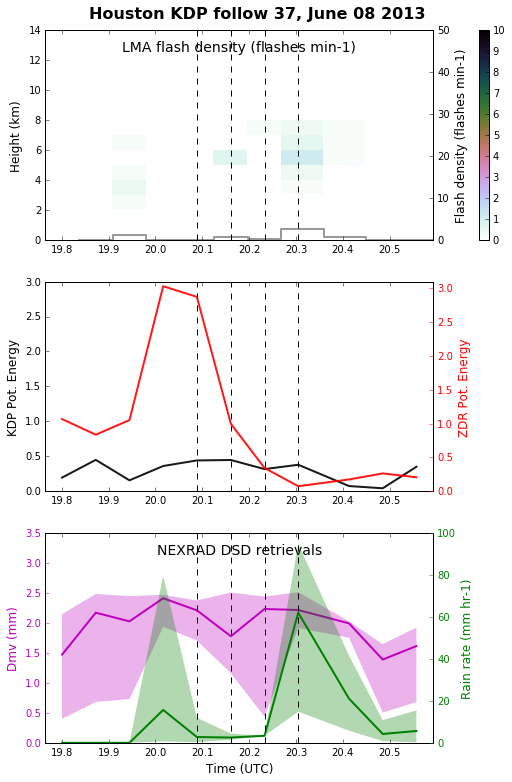

In [350]:
#plot_track_timeseries(9,vertlines=[3,4,5,6])
# plot_track_timeseries(22,origtrackno=6,vertlines=[5,6,7,8],start_idx=4,end_idx=11,
#                       distradius=2500.,distradius_d=2500.)
# plot_track_timeseries(28,origtrackno=9,vertlines=[3,4,5,6],start_idx=1,end_idx=8,
#                       distradius=2500.,distradius_d=2500.)
# plot_track_timeseries(42,origtrackno=18,vertlines=[1,2,3,4],
#                      distradius=2500.,distradius_d=2500.)
# plot_track_timeseries(74,origtrackno=35,distradius=2500.,distradius_d=2500.)
plot_track_timeseries(77,origtrackno=37,vertlines=[4,5,6,7],
                     distradius=2500.,distradius_d=2500.)
#..

/home/mvanlier/mvanlier/nexrad_khgx/dsd_20130608/grids/grid_rra_KHGX_20130608-170554.nc


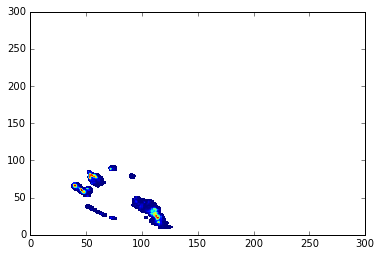

In [62]:
#..Load nexrad rain rate file
filee = dsdpath+rrafiles[14]
print filee
nc = Dataset(filee,'r')
rra = nc.variables['precipitation_rate_a'][0,:,:,:].sum(axis=0)   #..Flatten into 2d
nc.close()

plt.pcolormesh(rra)

In [115]:
dist_to_khgx_thresh = 150000.    #.. (m)


In [325]:
def plot_track_slices(trackno,origtrackno=999,tvec=[0,1,2,3],plot_zhh=False):
    frzl = 4300.*1.e-3
    if len(tvec) != 4:
        raise ValueError('wrongsize_tvec')
    i=trackno
    #i=1
    #..Set the start/end indices for the full timerange
    nex_hod_chop = []
    dsd_hod_chop = []
    dsd_idx_chop = []
    tmin = t1.frame[t1.particle==partnumlist[i]].min()
    tmax = t1.frame[t1.particle==partnumlist[i]].max()
    #print 'tmin,tmax = ',tmin,tmax
    nt = tmax-tmin+1
    ja = 0
    #..Get a list of HOD
    for j in xrange(tmin,tmax+1):
        filenm = radfiles[j]
        rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                       int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                     datetime.datetime(1970,1,1)).total_seconds()
        nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]

    nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
    hod_chop_edge = make_edge_vec(nex_hod_chop)

    #..Pull together strings, time, lat, and lon, to allow for analysis to follow
    logcon = t1.particle==partnumlist[i]
    tidx = t1.index[logcon].values
    xidx = (np.around(t1.x[logcon].values)).astype(int)
    yidx = (np.around(t1.y[logcon].values)).astype(int)
    lon_track = lon_grid[[yidx,xidx]]
    lat_track = lat_grid[[yidx,xidx]]

    av_dist_of_track = np.mean(dist_to_khgx[[yidx,xidx]])

    if av_dist_of_track>dist_to_khgx_thresh:
        print 'track exceeds max distance to khgx'
        raise ValueError('maxdisttoobig')
    else:
        pass


    #..Make sure no time indices are being skipped. If they are, do an interpolation to reconstruct
    #..where the things should be going
    if (tidx.shape[0]==nex_hod_chop.shape[0]):
        print 'all is well, no gaps in the tracking, numsteps = ',nex_hod_chop.shape[0]
    else:
        print 'number of steps in track = ',tidx.shape[0],', should be =',nex_hod_chop.shape[0]
        tidx_new = np.array(range(tmin,tmax+1))
        f = interpolate.interp1d(tidx,t1.x[logcon].values)
        xidx = (np.around(f(tidx_new))).astype(int)
        f = interpolate.interp1d(tidx,t1.y[logcon].values)
        yidx = (np.around(f(tidx_new))).astype(int)
        lat_track = lat_grid[[yidx,xidx]]
        lon_track = lon_grid[[yidx,xidx]]
        tidx = tidx_new

    print tidx
    print nex_hod_chop.shape
    print dmv_epoch.shape
    #..It is at this point that matches should be made from 
    #..find closest DSD file epoch and index
    dmv_hod_chop = []
    dmv_idx_chop = []
    nwi_hod_chop = []
    nwi_idx_chop = []
    for j in xrange(tidx.shape[0]):
        iddx = np.argmin(abs(dmv_epoch-nex_hod_chop[j]*3600.-base_epoch))
        dmv_hod_chop = np.r_[dmv_hod_chop,dmv_epoch[iddx]]
        dmv_idx_chop = np.r_[dmv_idx_chop,iddx]
        iddx = np.argmin(abs(nwi_epoch-nex_hod_chop[j]*3600.-base_epoch))
        nwi_hod_chop = np.r_[nwi_hod_chop,nwi_epoch[iddx]]
        nwi_idx_chop = np.r_[nwi_idx_chop,iddx]
    dmv_idx_chop = dmv_idx_chop.astype(np.int)
    dmv_hod_chop = (dmv_hod_chop - base_epoch)/3600.
    dmv_hod_chop_edge = make_edge_vec(dmv_hod_chop)
    nwi_idx_chop = nwi_idx_chop.astype(np.int)
    nwi_hod_chop = (nwi_hod_chop - base_epoch)/3600.
    nwi_hod_chop_edge = make_edge_vec(nwi_hod_chop)


    #..Load LMA lightning data
    if not(lmapath):
        raise ValueError('No LMA path specified')
    lyt_files = []
    numfiles  = 0
    for root,dirs,files in walklevel(lmapath,level=0):
        for file in files:
            if file.startswith('flash_start'):
                lyt_files.append(file)
                numfiles += 1
    lyt_files = sorted(lyt_files)
    #..Loop over all files, string flash information together into one big array
    fl_raw = np.loadtxt(lmapath+lyt_files[0],ndmin=2)
    for j in range(1,numfiles):
        fl_raw = np.vstack((fl_raw,np.loadtxt(basepath+midpath+lyt_files[j],ndmin=2)))
    fl_raw[:,0] = fl_raw[:,0]/3600. #..sod -> hod
    
    
    if plot_zhh:
        fig = plt.figure(figsize=[16,11])
        gs1 = gridspec.GridSpec(4,6,width_ratios=[1,10,10,10,10,10])
        gs1.update(left=0.02, right=0.95, bottom=0.05, top=0.92)
        offset = 1
    else:
        fig = plt.figure(figsize=[14,11])
        gs1 = gridspec.GridSpec(4, 5,width_ratios=[1,10,10,10,10])
        gs1.update(left=0.02, right=0.95, bottom=0.05, top=.92)    #..Loop over all the time indices and... something
        offset = 0
    for j in range(len(tvec)):
        #jj = j-tmin
        jj = tvec[j]
        #print 'i,j = ', i,j
        #if (len(t1.x[(t1.particle==partnumlist[i])&(t1.frame==j)])) #..Make sure length ~= 0

        #..Paste below from particle-following code from plot_houston_lma
        #..First let's get the basics -- horizontal and vertical slices following the action
        filenm = radfiles[jj+tmin]
        dt = datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                       int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3]))
        
        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[jj]
        maxlon = lon_track[jj]
        
        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]

        filee = nexrad_path+radfiles[jj+tmin]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()
        print filee
        
        #..Load DSD files
        filee = dsdpath+dmvfiles[dmv_idx_chop[jj]]
        nc = Dataset(filee,'r')
        dmv = nc.variables['Dmv'][0,:,:,:]
        alt_dsd = nc.variables['z_disp'][:]+35.
        nc.close
        filee = dsdpath+nwifiles[nwi_idx_chop[jj]]
        print filee
        nc = Dataset(filee,'r')
        nwi = np.zeros((20,260,260))
        nwi = nc.variables['NwID'][0,:,:,:]
        nc.close
        

        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]

        #..Chop down lightning data
        logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
        #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
        sub_tim = fl_raw[:,0][logcon]
        sub_lat = fl_raw[:,1][logcon]
        sub_lon = fl_raw[:,2][logcon]
        sub_alt = fl_raw[:,3][logcon]
        sub_color = (t_e-sub_tim)*60. #..to mins...
        #..Make further cut based on 
        sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
        logcon = sub_dist<distradius
        ssub_tim = sub_tim[logcon]
        ssub_lat = sub_lat[logcon]
        ssub_lon = sub_lon[logcon]
        ssub_alt = sub_alt[logcon]
        ssub_color = sub_color[logcon]
        ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
        
        #gs = gridspec.GridSpec(3, 3,width_ratios=[5,2,2])

        
        #gs2 = gridspec.GridSpec(3,1)
        #gs2.update(left=0.55, right=0.92, bottom=0.05, top=.95)
        
        ax0 = plt.subplot(gs1[j,0])
        ax0.text(.2,.5,dt.strftime("%H:%M:%S UTC"),ha='center',va='center',fontsize=16,rotation=90)
        ax0.axis('off')

        
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        #print np.argmin(dist_to_center)
        cent_idx = np.unravel_index(np.argmin(dist_to_center), dist_to_center.shape)
        
        if plot_zhh:
            axz = plt.subplot(gs1[j,1])
            im2 = axz.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,zhh[0:19,cent_idx[0]-15:cent_idx[0]+15,cent_idx[1]],
                                 cmap=pcm.NWSRef,vmin=-4,vmax=75.,rasterized=True)
            plt.scatter(np.array(ssub_y)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',
                    cmap=cm.cool,vmin=0.,vmax=6.)
                    #cmap=cm.pink_r,vmin=0.,vmax=6.)
            plt.plot([-15,15.],[frzl,frzl],'k:',lw=2)
            axz.set_ylim(0,10000/1.e3)
            axz.set_xlim(-15,15)
            plt.colorbar(im2)
            axz.set_ylabel('Height (km)',fontsize=12)
            if j==3:
                axz.set_xlabel('Distance (km)',fontsize=12)
            plt.title('ZHH (dBz) S-N',fontsize=14)
        ax1 = plt.subplot(gs1[j,1+offset])
        im2=ax1.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,kdp[0:19,cent_idx[0]-15:cent_idx[0]+15,cent_idx[1]],
                           cmap=pcm.RRate11,vmin=-.2,vmax=2.,rasterized=True)
        plt.scatter(np.array(ssub_y)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',
                    cmap=cm.autumn,vmin=0.,vmax=6.)
                    #cmap=cm.pink_r,vmin=0.,vmax=6.)
        plt.plot([-15,15.],[frzl,frzl],'k:',lw=2)
        ax1.set_ylim(0,10000/1.e3)
        ax1.set_xlim(-15,15)
        plt.colorbar(im2)
        if not(plot_zhh):
            ax1.set_ylabel('Height (km)',fontsize=12)
        if j==3:
            ax1.set_xlabel('Distance (km)',fontsize=12)
        plt.title('KDP (deg/km) S-N',fontsize=14)


        #ax2 = plt.subplot(gs[1,1])
        ax2 = plt.subplot(gs1[j,2+offset])
        im3=ax2.pcolormesh(np.arange(-15,15.3,1),ze[0:20]/1.e3,zdr_proc[0:19,cent_idx[0]-15:cent_idx[0]+15,cent_idx[1]],
                           cmap=pcm.RefDiff,vmin=-.5,vmax=3.,rasterized=True)
        plt.scatter(np.array(ssub_y)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',
                    cmap=cm.autumn,vmin=0.,vmax=6.)
                    #cmap=cm.pink_r,vmin=0.,vmax=6.)
        plt.plot([-15,15.],[frzl,frzl],'k:',lw=2)
        ax2.set_ylim(0,10000/1.e3)
        ax2.set_xlim(-15,15)
        plt.colorbar(im3)
        #ax2.set_ylabel('Height (km)',fontsize=12)
        if j==3:
            ax2.set_xlabel('Distance (km)',fontsize=12)
        plt.title('ZDR (dB) S-N',fontsize=14)
        
        dist_to_center_d = haversine(lat_grid_ds,lon_grid_ds,maxlat,maxlon)
        #print np.argmin(dist_to_center)
        cent_idx_d = np.unravel_index(np.argmin(dist_to_center_d), dist_to_center_d.shape)
        
        ax3 = plt.subplot(gs1[j,3+offset])
        im3=ax3.pcolormesh(np.arange(-15,15.3,1),alt_dsd/1.e3,
                           dmv[:,cent_idx_d[0]-15:cent_idx_d[0]+15,cent_idx_d[1]],
                           cmap=cm.cubehelix_r,vmin=0.,vmax=3.,rasterized=True)
        plt.scatter(np.array(ssub_y)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',
                    cmap=cm.autumn,vmin=0.,vmax=6.)
#                    cmap=cm.pink_r,vmin=0.,vmax=6.)
        plt.plot([-15,15.],[frzl,frzl],'k:',lw=2)
        ax3.set_ylim(0,10000/1.e3)
        ax3.set_xlim(-15,15)
        plt.colorbar(im3)
        #ax2.set_ylabel('Height (km)',fontsize=12)
        if j==3:
            ax3.set_xlabel('Distance (km)',fontsize=12)
        plt.title('Dmv (mm) S-N',fontsize=14)
        
        ax4 = plt.subplot(gs1[j,4+offset])
        im4=ax4.pcolormesh(np.arange(-15,15.3,1),alt_dsd/1.e3,
                           nwi[:,cent_idx_d[0]-15:cent_idx_d[0]+15,cent_idx_d[1]],
                           cmap=cm.cubehelix_r,vmin=0.,vmax=5.,rasterized=True)
        plt.scatter(np.array(ssub_y)/1000.,ssub_alt/1.e3,s=20.,c=ssub_color,alpha=.4,edgecolor='none',
                    cmap=cm.autumn,vmin=0.,vmax=6.)
#                    cmap=cm.pink_r,vmin=0.,vmax=6.)
        plt.plot([-15,15.],[frzl,frzl],'k:',lw=2)
        ax4.set_ylim(0,10000/1.e3)
        ax4.set_xlim(-15,15)
        plt.colorbar(im4)
        #ax2.set_ylabel('Height (km)',fontsize=12)
        if j==3:
            ax4.set_xlabel('Distance (km)',fontsize=12)
        plt.title('log(Nw) S-N',fontsize=14)
        
    plt.suptitle('Houston KDP follow '+str(origtrackno)+', June 08 2013',
              fontsize=16,fontweight='bold')
    if plot_zhh:
        fig.savefig('khgx_trsl_z_20130608_'+str(origtrackno).zfill(3)+'.pdf')
    else:
        fig.savefig('khgx_trsl_20130608_'+str(origtrackno).zfill(3)+'.pdf')
    #fig.savefig('test_plot_track_slice.pdf')
    #..

In [301]:
dist_to_khgx = haversine(lat_grid,lon_grid,khgx_lat,khgx_lon)
#print np.argmin(dist_to_center)
khgx_idx = np.unravel_index(np.argmin(dist_to_khgx), dist_to_khgx.shape)
print khgx_idx

(200, 199)


In [25]:
filee='/home/mvanlier/mvanlier/nexrad_khgx/dsd_20130608/grids/grid_NwID_20130608_173610.nc'
nc = Dataset(filee,'r')
nwi = np.zeros((20,260,260))
poop = nc.variables['NwID'][0,:,:,:]
nc.close

<function close>

number of steps in track =  7 , should be = 9
[85 86 87 88 89 90 91 92 93]
(9,)
(67,)
/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid02_khgx_20130608_211639.nc
/home/mvanlier/mvanlier/nexrad_khgx/dsd_20130608/grids/grid_NwID_20130608_205504.nc
/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid02_khgx_20130608_212059.nc
/home/mvanlier/mvanlier/nexrad_khgx/dsd_20130608/grids/grid_NwID_20130608_205504.nc
/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid02_khgx_20130608_212518.nc
/home/mvanlier/mvanlier/nexrad_khgx/dsd_20130608/grids/grid_NwID_20130608_205504.nc
/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid02_khgx_20130608_212937.nc
/home/mvanlier/mvanlier/nexrad_khgx/dsd_20130608/grids/grid_NwID_20130608_205504.nc


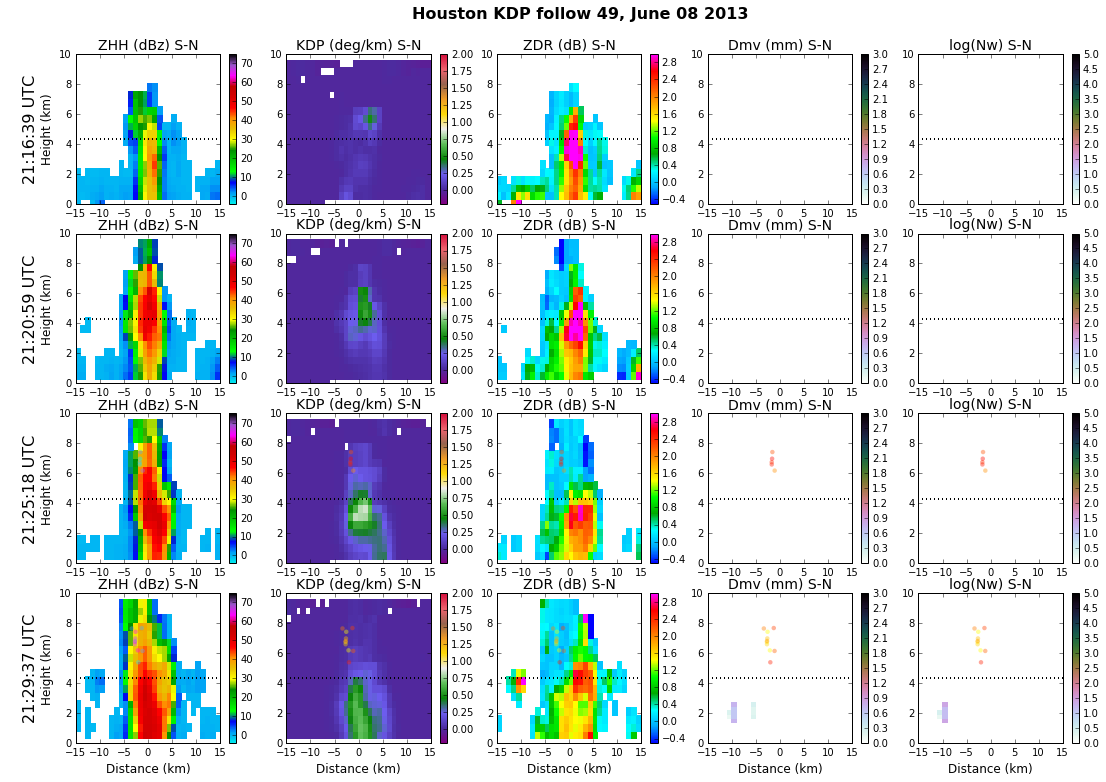

In [332]:
#plot_track_slices(9,origtrackno=1)
#plot_track_slices(22,origtrackno=6,tvec=[5,6,7,8],plot_zhh=True)
#plot_track_slices(28,origtrackno=9,tvec=[3,4,5,6],plot_zhh=True)
#plot_track_slices(42,origtrackno=18,tvec=[1,2,3,4],plot_zhh=True)
#plot_track_slices(75,origtrackno=35,tvec=[4,5,6,7],plot_zhh=True)
#plot_track_slices(75,origtrackno=35,tvec=[4,5,6,7],plot_zhh=True)
##plot_track_slices(77,origtrackno=37,tvec=[4,5,6,7])
#plot_track_slices(76,origtrackno=37,tvec=[4,5,6,7],plot_zhh=True)
plot_track_slices(101,origtrackno=49,plot_zhh=True)
#..

In [123]:
print orig_track_no
print orig_track_no[17]
print orig_track_no[49]

[   9.   10.   18.   19.   20.   22.   24.   25.   28.   31.   32.   33.
   34.   35.   37.   38.   42.   43.   45.   48.   50.   52.   55.   57.
   60.   61.   64.   65.   66.   67.   69.   71.   72.   73.   74.   75.
   78.   79.   83.   85.   87.   88.   89.   91.   92.   94.   95.   98.
  101.  102.  103.  104.  105.  108.]
43.0
102.0


In [1]:
print lon_track.shape

NameError: name 'lon_track' is not defined

In [306]:
def plot_track_map(orig_track_nos,real_track_nos,stix=None,enix=None,do_polygons=True):
    
    hx_lat = 29+45./60.+46./3600. 
    hx_lon = -1.*(95.+22./60+59./3600)
    
    fig=plt.figure(figsize=(10,9))
    #m = Basemap(width=400000,height=350000,projection='lcc',
    #                resolution='i',lon_0 =radr_lon,lat_0=radr_lat,lat_1=28.,lat_2=32.,epsg=2278)
    m = Basemap(llcrnrlon=-96.,llcrnrlat=29.,urcrnrlon=-94.5,urcrnrlat=30.5,epsg=2278,resolution='h') #..zoom 9
    #m = Basemap(llcrnrlon=-98.,llcrnrlat=28.,urcrnrlon=-93.8,urcrnrlat=31.3,epsg=2278,resolution='h') #..default
    #m = Basemap(llcrnrlon=-96.3,llcrnrlat=28.7,urcrnrlon=-93.8,urcrnrlat=30.3,epsg=4326,resolution='h')
    parallels = np.arange(round(radr_lat,0)-5.,round(radr_lat,0)+5,.5)
    meridians = np.arange(round(radr_lon,0)-5,round(radr_lon,0)+5,.5)
    #m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
    m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', service='ESRI_Imagery_World_2D', 
                  xpixels=1000, ypixels=None, dpi=96, verbose=False)
    #plt.show()
    #m.bluemarble()
    #m.shadedrelief()
    #m.etopo()

    #m.imshow(img)
    m.tissot(radr_lon,radr_lat,108./60.,100,edgecolor='r',facecolor='none')
    m.tissot(radr_lon,radr_lat,108./120.,100,edgecolor='r',facecolor='none')
    m.plot(radr_lon,radr_lat,latlon=True,marker='s',color='r')
    m.plot(hx_lon,hx_lat,latlon=True,marker='s',color='w',markersize=10)
    #m.plot(-95.3,29.7,latlon=True,marker='s',color='g',markersize=10)
    m.drawparallels(parallels,color='w',labels=[True,False,False,False])
    m.drawmeridians(meridians,color='w',labels=[False,False,False,True])
    m.drawstates(color='w')
    m.drawcoastlines(color='w')
    
    if do_polygons:
        m.plot([-95.53,-95.08],[30.16,30.08],latlon=True,color='y',lw=2)
        m.plot([-95.573060,-95.53],[29.847739,30.16],latlon=True,color='y',lw=2)
        m.plot([-95.160033,-95.08],[29.772985,30.08],latlon=True,color='y',lw=2)
        m.plot([-95.573060,-95.160033],[29.847739,29.772985],latlon=True,color='y',lw=2)
        x,y = m(-95.08,30.08)
        plt.text(x-100000,y-5000.,'636@23%',fontsize=14,color='y')

        m.plot([-96.964975,-96.762590],[28.272033,28.364897],latlon=True,color='y',lw=2)
        m.plot([-96.964975,-96.850807],[28.272033,27.898124],latlon=True,color='y',lw=2)
        m.plot([-96.683910,-96.762590],[27.946578,28.364897],latlon=True,color='y',lw=2)
        x,y = m(-96.9649750,28.272033)
        plt.text(x-40000,y+5000.,'354@20%',fontsize=14,color='y')
        #m.plot([-95.160033,-95.08],[29.772985,30.08],latlon=True,color='y',lw=2)
        #m.plot([-95.573060,-95.160033],[29.847739,29.772985],latlon=True,color='y',lw=2)

        m.plot([-94.568841,-94.317973],[29.904596,29.819477],latlon=True,color='y',lw=2)
        m.plot([-94.723940,-94.469295],[29.716251,29.587392],latlon=True,color='y',lw=2)
        m.plot([-94.723940,-94.568841],[29.716251,29.904596],latlon=True,color='y',lw=2)
        m.plot([-94.469295,-94.317973],[29.587392,29.819477],latlon=True,color='y',lw=2)
        x,y = m(-94.568,29.9045)
        plt.text(x+5000,y,'482@23%',fontsize=14,color='y')

        m.plot([-97.766,-97.3],[29.15,29.169],latlon=True,color='y',lw=2)
        m.plot([-97.649,-97.279],[28.695,28.872],latlon=True,color='y',lw=2)
        m.plot([-97.766,-97.649],[29.15,28.695],latlon=True,color='y',lw=2)
        m.plot([-97.279,-97.3],[28.872,29.169],latlon=True,color='y',lw=2)
        x,y = m(-97.649,29.169)
        plt.text(x-10000,y+5000,'498@23%',fontsize=14,color='y')

        m.plot([-95.47,-95.00],[30.2,30.09],latlon=True,color='y',lw=2)
        m.plot([-95.35,-94.82],[30.7,30.6],latlon=True,color='y',lw=2)
        m.plot([-95.47,-95.35],[30.2,30.7],latlon=True,color='y',lw=2)
        m.plot([-95.00,-94.82],[30.09,30.6],latlon=True,color='y',lw=2)
        x,y = m(-94.82,30.6)
        plt.text(x,y,'762@23%',fontsize=14,color='y')

        x,y = m(hx_lon,hx_lat)
        plt.text(x-60000,y+1000.,'Houston',fontsize=18,color='w')

        x,y = m(radr_lon,radr_lat)
        plt.text(x-20000,y-14000.,'KHGX',fontsize=18,color='r')


    for j in range(len(orig_track_nos)):
        i = orig_track_nos[j]
        tmin = t1.frame[t1.particle==partnumlist[i]].min()
        tmax = t1.frame[t1.particle==partnumlist[i]].max()
        #print 'tmin,tmax = ',tmin,tmax
        nt = tmax-tmin+1
        ja = 0
        #..Set the start/end indices for the full timerange
        nex_hod_chop = []
        dsd_hod_chop = []
        dsd_idx_chop = []
        ja = 0
        #..Get a list of HOD
        for k in xrange(tmin,tmax+1):
            filenm = radfiles[k]
            rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                           int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                         datetime.datetime(1970,1,1)).total_seconds()
            nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]

        nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
        hod_chop_edge = make_edge_vec(nex_hod_chop)

        #..Pull together strings, time, lat, and lon, to allow for analysis to follow
        logcon = t1.particle==partnumlist[i]
        tidx = t1.index[logcon].values
        xidx = (np.around(t1.x[logcon].values)).astype(int)
        yidx = (np.around(t1.y[logcon].values)).astype(int)
        lon_track = lon_grid[[yidx,xidx]]
        lat_track = lat_grid[[yidx,xidx]]

        

        #..Make sure no time indices are being skipped. If they are, do an interpolation to reconstruct
        #..where the things should be going
        if (tidx.shape[0]==nex_hod_chop.shape[0]):
            print 'all is well, no gaps in the tracking, numsteps = ',nex_hod_chop.shape[0]
        else:
            print 'number of steps in track = ',tidx.shape[0],', should be =',nex_hod_chop.shape[0]
            tidx_new = np.array(range(tmin,tmax+1))
            f = interpolate.interp1d(tidx,t1.x[logcon].values)
            xidx = (np.around(f(tidx_new))).astype(int)
            f = interpolate.interp1d(tidx,t1.y[logcon].values)
            yidx = (np.around(f(tidx_new))).astype(int)
            lat_track = lat_grid[[yidx,xidx]]
            lon_track = lon_grid[[yidx,xidx]]
            tidx = tidx_new
        if enix:
            m.plot(lon_track[stix[j]:enix[j]],lat_track[stix[j]:enix[j]],color='c',lw=3,latlon=True)
            x,y = m(lon_track[stix[j]],lat_track[stix[j]])
            plt.text(x-10000,y-10000,str(real_track_nos[j]),color='c',fontsize=16)
        else:
            m.plot(lon_track,lat_track,color='c',lw=2,latlon=True)            
    fig.savefig('houston_track_map_09.png',dpi=100)

all is well, no gaps in the tracking, numsteps =  14
number of steps in track =  8 , should be = 13
number of steps in track =  9 , should be = 11


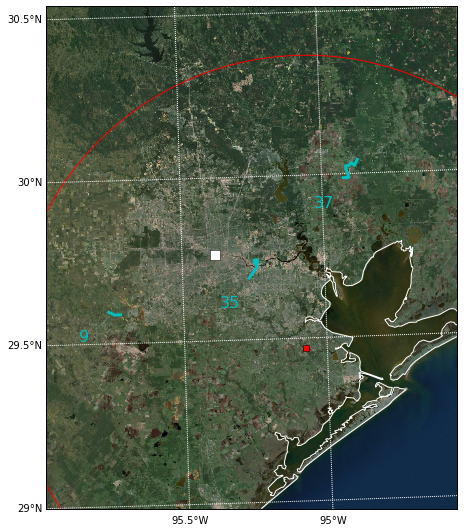

In [307]:
# rtn = np.array([9,35,37,49])
# otn = np.array([28,75,76,101])
# stix=[2,3,0,0]
# enix=[8,-1,9,-1]

rtn = np.array([9,35,37])
otn = np.array([28,75,76])
stix=[2,3,0]
enix=[8,-1,9]

plot_track_map(otn,rtn,stix=stix,enix=enix,do_polygons=False)
#plot_track_map(otn,rtn,stix=stix,enix=enix)
#..

/home/mvanlier/mvanlier/nexrad_khgx/dsd_20130608/grids/grid_Dmv_20130608_161151.nc
(20, 260, 260)
/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid02_khgx_20130608_161151.nc
(30, 400, 400)


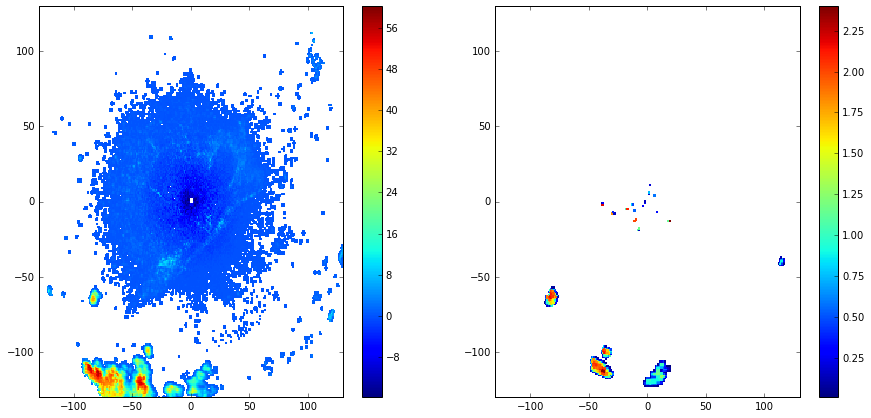

In [172]:
#..This aint looking right, so let's just take a look at what the grids look like, ok?
filee = dsdpath+dmvfiles[2]
#filee = dsdpath+dsdfiles[5]
nc = Dataset(filee,'r')
dmv = nc.variables['Dmv'][0,:,:,:]
alt_dsd = nc.variables['z_disp'][:]+35.
nc.close
print filee
print dmv.shape
#..
filee = nexrad_path+radfiles[16]
nc = Dataset(filee,'r')
zhh = nc.variables['reflectivity'][0,:,:,:]
zdr = nc.variables['differential_reflectivity'][0,:,:,:]
kdp = nc.variables['kdp'][0,:,:,:]
rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
nc.close()
print filee
print zhh.shape

fig=plt.figure(figsize=(15,7))
ax0 = fig.add_subplot(121)
im0= ax0.pcolormesh(np.linspace(-200,200,400),np.linspace(-200,200,400),zhh[2,:,:])
ax0.set_xlim(-130,130)
ax0.set_ylim(-130,130)
plt.colorbar(im0)
ax1 = fig.add_subplot(122)
im1=ax1.pcolormesh(np.linspace(-130,130,260),np.linspace(-130,130,260),dmv[:,:,:].max(axis=0))
ax1.set_xlim(-130,130)
ax1.set_ylim(-130,130)
plt.colorbar(im1)

In [72]:
xbuf = 50000.
ybuf = 50000.
#for i in range(4):
tnt = 0   #...Track Number True
orig_track_no = []

for i in range(numpart):
    #..Set the start/end indices for the full timerange
    nex_hod_chop = []
    dsd_hod_chop = []
    dsd_idx_chop = []
    tmin = t1.frame[t1.particle==partnumlist[i]].min()
    tmax = t1.frame[t1.particle==partnumlist[i]].max()
    #print 'tmin,tmax = ',tmin,tmax
    nt = tmax-tmin+1
    ja = 0
    #..Get a list of HOD
    for j in xrange(tmin,tmax+1):
        filenm = radfiles[j]
        rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                       int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                     datetime.datetime(1970,1,1)).total_seconds()
        nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]
        
    nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
    hod_chop_edge = make_edge_vec(nex_hod_chop)
    
    #..Pull together strings, time, lat, and lon, to allow for analysis to follow
    logcon = t1.particle==partnumlist[i]
    tidx = t1.index[logcon].values
    xidx = (np.around(t1.x[logcon].values)).astype(int)
    yidx = (np.around(t1.y[logcon].values)).astype(int)
    lon_track = lon_grid[[yidx,xidx]]
    lat_track = lat_grid[[yidx,xidx]]
    
    av_dist_of_track = np.mean(dist_to_khgx[[yidx,xidx]])
    
    if av_dist_of_track>dist_to_khgx_thresh:
        continue
    else:
        tnt += 1
        print 'particles plotted = ',tnt
        orig_track_no = np.r_[orig_track_no,i]

particles plotted =  1
particles plotted =  2
particles plotted =  3
particles plotted =  4
particles plotted =  5
particles plotted =  6
particles plotted =  7
particles plotted =  8
particles plotted =  9
particles plotted =  10
particles plotted =  11
particles plotted =  12
particles plotted =  13
particles plotted =  14
particles plotted =  15
particles plotted =  16
particles plotted =  17
particles plotted =  18
particles plotted =  19
particles plotted =  20
particles plotted =  21
particles plotted =  22
particles plotted =  23
particles plotted =  24
particles plotted =  25
particles plotted =  26
particles plotted =  27
particles plotted =  28
particles plotted =  29
particles plotted =  30
particles plotted =  31
particles plotted =  32
particles plotted =  33
particles plotted =  34
particles plotted =  35
particles plotted =  36
particles plotted =  37
particles plotted =  38
particles plotted =  39
particles plotted =  40
particles plotted =  41
particles plotted =  42
p

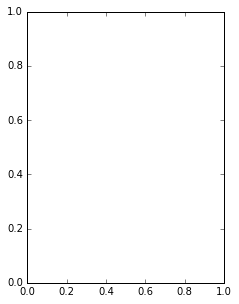

In [84]:
fig = plt.figure(figsize=[14,11])
gs1 = gridspec.GridSpec(3, 2,height_ratios=[2,1,1])
ax0 = fig.add_subplot(gs1[0:2,0])
gs1.update(left=0.05, right=0.48)

gs2 = gridspec.GridSpec(3,1)
gs2.update(left=0.55, right=0.98)

In [33]:
blah=None
not(blah)

True

In [24]:
#..Some parameters
dist_to_khgx_thresh = 120000.    #.. (m)
mask_rhothresh = 0.8
mask_dbzthresh = 15.
distradius=10000.                #..When collecting statistics around KDP col, this is the radius used
kdpthr=0.5
zdrthr=0.75

#..Now a quick scatter-plot code. Requires the previous cell to be run first
xbuf = 50000.
ybuf = 50000.
distradius=10000.                #..When collecting statistics around KDP col, this is the radius used
#for i in range(4):
tnt = 0   #...Track Number True

#..This removes zero-length cells (or missing particle numbers) and makes a nice list of particle numbers
#..that can be used in the next thingy  ..cut from kdp_cell_tracker
numpart = 0
partnumlist = []
for i in range(int(t1.particle.min()),int(t1.particle.max()+1)):
    if len(t1[t1.particle==i])!=0:
        numpart += 1
        partnumlist.append(i)
print numpart
#...
starting_fresh=True   #..Do the initial investigation into available NEXRAD gridded data files
if starting_fresh:
    #..Get a list of radar data files. 
    #nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/'
    nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/'
    lmapath    = '/home/mvanlier/mvanlier/lma_houston/old_folders/130608/unzipped/'
    yyyymmdd = nexrad_path[-9:-1]
    radfile_start = 'grid00_khgx'
    numfiles = 0
    radfiles = []
    for root,dirs,files in walklevel(nexrad_path,level=0):
        for file in files:
            if file.startswith(radfile_start):
                radfiles.append(file)
                numfiles += 1
    #print radfiles
    radfiles = sorted(radfiles)
    filenm = radfiles[0]

    #..Load up things that don't change file-by-file
    filenm = nexrad_path+radfiles[0]
    base_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10])) -
                     datetime.datetime(1970,1,1)).total_seconds()
    nc = Dataset(filenm,'r')
    xd = nc.variables['x_disp'][:]
    yd = nc.variables['y_disp'][:]
    zd = nc.variables['z_disp'][:]
    #..Make vectors of cell edges
    xe = make_edge_vec(xd)
    ye = make_edge_vec(yd)
    ze = make_edge_vec(zd)
    alt= zd + zsfc
    alte=ze + zsfc
    #..Get lat/lon from dx,dy
    lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
    dist_to_khgx = haversine(radr_lat,radr_lon,lat_grid,lon_grid)
    #..
    zgrid = np.zeros((len(zd),len(yd),len(xd)))
    for j in range(len(zd)):
        zgrid[j,:,:] = zd[j]
    nc.close()

for i in range(numpart):
    #..Set the start/end indices for the full timerange
    nex_hod_chop = []
    tmin = t1.frame[t1.particle==partnumlist[i]].min()
    tmax = t1.frame[t1.particle==partnumlist[i]].max()
    #print 'tmin,tmax = ',tmin,tmax
    nt = tmax-tmin+1
    ja = 0
    #..Get a list of HOD
    for j in xrange(tmin,tmax+1):
        filenm = radfiles[j]
        rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                       int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                     datetime.datetime(1970,1,1)).total_seconds()
        nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]
    nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
    hod_chop_edge = make_edge_vec(nex_hod_chop)

    
    #..Pull together strings, time, lat, and lon, to allow for analysis to follow
    logcon = t1.particle==partnumlist[i]
    tidx = t1.index[logcon].values
    xidx = (np.around(t1.x[logcon].values)).astype(int)
    yidx = (np.around(t1.y[logcon].values)).astype(int)
    lon_track = lon_grid[[yidx,xidx]]
    lat_track = lat_grid[[yidx,xidx]]
    
    av_dist_of_track = np.mean(dist_to_khgx[[yidx,xidx]])
    
    if av_dist_of_track>dist_to_khgx_thresh:
        continue
    else:
        tnt += 1
        print 'particles plotted = ',tnt
        
        
    #..Make sure no time indices are being skipped. If they are, do an interpolation to reconstruct
    #..where the things should be going
    if (tidx.shape[0]==nex_hod_chop.shape[0]):
        print 'all is well, no gaps in the tracking, numsteps = ',nex_hod_chop.shape[0]
    else:
        print 'number of steps in track = ',tidx.shape[0],', should be =',nex_hod_chop.shape[0]
        tidx_new = range(tmin,tmax+1)
        f = interpolate.interp1d(tidx,t1.x[logcon].values)
        xidx = (np.around(f(tidx_new))).astype(int)
        f = interpolate.interp1d(tidx,t1.y[logcon].values)
        yidx = (np.around(f(tidx_new))).astype(int)
        lat_track = lat_grid[[yidx,xidx]]
        lon_track = lon_grid[[yidx,xidx]]
        tidx = tidx_new
        
    #..Load LMA lightning data
    if not(lmapath):
        raise ValueError('No LMA path specified')
    lyt_files = []
    numfiles  = 0
    for root,dirs,files in walklevel(lmapath,level=0):
        for file in files:
            if file.startswith('flash_start'):
                lyt_files.append(file)
                numfiles += 1
    lyt_files = sorted(lyt_files)
    #..Loop over all files, string flash information together into one big array
    fl_raw = np.loadtxt(lmapath+lyt_files[0],ndmin=2)
    for i in range(1,numfiles):
        fl_raw = np.vstack((fl_raw,np.loadtxt(basepath+midpath+lyt_files[i],ndmin=2)))
    fl_raw[:,0] = fl_raw[:,0]/3600. #..sod -> hod
    
    
    
    #..Do a prior loop to tabulate statistics
    kdp_sum_all =np.array([])
    zdr_sum_all =np.array([])
    kdp_99p_all =np.array([])
    zdr_99p_all =np.array([])
    kdp_pet_all =np.array([])
    zdr_pet_all =np.array([])
    kdptop = []
    zdrtop = []
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[j-tmin]
        maxlon = lon_track[j-tmin]
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)

        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()

        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]
        
        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]
        
        #..Chop down lightning data
        logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
        #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
        sub_tim = fl_raw[:,0][logcon]
        sub_lat = fl_raw[:,1][logcon]
        sub_lon = fl_raw[:,2][logcon]
        sub_alt = fl_raw[:,3][logcon]
        sub_color = (t_e-sub_tim)*60. #..to mins...
        #..Make further cut based on 
        sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
        logcon = sub_dist<distradius
        ssub_tim = sub_tim[logcon]
        ssub_lat = sub_lat[logcon]
        ssub_lon = sub_lon[logcon]
        ssub_alt = sub_alt[logcon]
        ssub_color = sub_color[logcon]
        ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
        #..make histogram info from lighting
        lma_zhist,be = np.histogram(ssub_alt,bins=np.arange(0.,15000.,1000.))
        if jj==0:
            lma_hall = lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))
        else:
            lma_hall = np.vstack((lma_hall,lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))))
        
        #..Now get pol radar statistics
        logconi = dist_to_center<distradius
        vol_ones = zdr_proc*0.+1
        kdp_99p = np.percentile(kdp_proc[9:15,logconi],95.)
        zdr_99p = np.percentile(zdr_proc[9:15,logconi],95.)
        #print kdp_99p
        logconk = np.logical_and(logconi,kdp_int>kdp_99p)
        kdp_sum = kdp_proc[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
        kdp_pe = kdp_proc*zgrid
        zdr_pe = zdr_proc*zgrid
        if not(bool(vol_ones[9:15,logconk].sum()>0.)):
            print 'isempty'
            kdp_sum = -99.
            zdr_sum = -99.
            kdp_pet = 0.
            zdr_pet = 0.
        else:
            zdr_sum = zdr[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
            kdp_pet = kdp_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
            zdr_pet = zdr_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
        try:
            kdp_sum_all = np.r_[kdp_sum_all,kdp_sum]
        except ValueError:
            kdp_sum_all = np.r_[kdp_sum_all,-99.]
        try:
            zdr_sum_all = np.r_[zdr_sum_all,zdr_sum]
        except ValueError:
            zdr_sum_all = np.r_[zdr_sum_all,-99.]
        try:
            kdp_pet_all = np.r_[kdp_pet_all,kdp_pet]
        except ValueError:
            kdp_pet_all = np.r_[kdp_pet_all,-99.]
        try:
            zdr_pet_all = np.r_[zdr_pet_all,zdr_pet]
        except ValueError:
            zdr_pet_all = np.r_[zdr_pet_all,-99.]
        kdp_99p_all = np.r_[kdp_99p_all,kdp_99p]
        zdr_99p_all = np.r_[zdr_99p_all,zdr_99p]
        if (zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])].any()):
            kdptop = np.r_[kdptop,np.max(zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])])]
        else:
            kdptop = np.r_[kdptop,0.]
        if (zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))].any()):
            zdrtop = np.r_[zdrtop,max(zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))])]
        else:
            zdrtop = np.r_[zdrtop,0.]
    
    #..Do a prior loop to tabulate statistics
#     kdp_sum_all =np.array([])
#     zdr_sum_all =np.array([])
#     kdp_99p_all =np.array([])
#     zdr_99p_all =np.array([])
#     kdp_pet_all =np.array([])
#     zdr_pet_all =np.array([])
#     kdptop = []
#     zdrtop = []
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[j-tmin]
        maxlon = lon_track[j-tmin]
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)

        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()

        #..
        logconi = dist_to_center<distradius
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]
        
        
        fig = plt.figure(figsize=(10,9))
        gs  = gridspec.GridSpec(6, 2,width_ratios=[1,3])
        #..
        ax = fig.add_subplot(gs[0:2,0])
        plt.scatter(kdp_proc[14:19,logconi],zdr_proc[14:19,logconi],s=50,c='k',alpha=.1,edgecolor='none')
        plt.plot([0.,2.],[0.,0.],'r:')
        ax.set_xlim(0,2.)
        ax.set_ylim(-1,3.)
        plt.title('7-9 km',fontsize=12,fontweight='bold')
        ax.set_xlabel('KDP',fontsize=11)
        ax.set_ylabel('ZDR',fontsize=11)
        #..
        ax = fig.add_subplot(gs[2:4,0])
        plt.scatter(kdp_proc[10:14,logconi],zdr_proc[10:14,logconi],s=50,c='k',alpha=.1,edgecolor='none')
        plt.plot([0.,2.],[0.,0.],'r:')
        ax.set_xlim(0,2.)
        ax.set_ylim(-1,3.)
        plt.title('5-7 km',fontsize=12,fontweight='bold')
        ax.set_xlabel('KDP',fontsize=11)
        ax.set_ylabel('ZDR',fontsize=11)
        #..
        ax = fig.add_subplot(gs[4:,0])
        plt.scatter(kdp_proc[6:10,logconi],zdr_proc[6:10,logconi],s=50,c='k',alpha=.1,edgecolor='none')
        plt.plot([0.,2.],[0.,0.],'r:')
        ax.set_xlim(0,2.)
        ax.set_ylim(-1,3.)
        plt.title('3-5 km',fontsize=12,fontweight='bold')
        ax.set_xlabel('KDP',fontsize=11)
        ax.set_ylabel('ZDR',fontsize=11)
        #..
        ax6 = fig.add_subplot(gs[0:3,1])
        pm = plt.pcolormesh(hod_chop_edge,be,lma_hall.T,cmap=cm.cubehelix_r,vmin=0.,vmax=20.)
        ax6.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000.],'r--')
        ax6.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax6.set_ylim(be[0],be[-1])
        ax6.set_xlabel('Hour of Day (UTC)')
        ax6.set_ylabel('Height (m)')
        plt.colorbar(pm)
        ax6a = ax6.twinx()
        ax6a.step(hod_chop_edge[1:],lma_hall.sum(axis=1),'k',where='pre',linewidth=2,alpha=.4)
        ax6a.set_ylim(0.,100.)
        plt.title('LMA flash density (flashes min-1)')
        #..
        #kdptop = fl_data['kdptop']
        #zdrtop = fl_data['zdrtop']
        ax7 = fig.add_subplot(gs[3:,1])
        #ax7.step(hod_chop_edge[1:],kdptop,'k:')
        #ax7.step(hod_chop_edge[1:],zdrtop,'r:')
        ax7.plot(nex_hod_chop,kdptop,'k',label='kdp col top',alpha=.3)
        ax7.plot(nex_hod_chop,zdrtop,'r',label='zdr col top',alpha=.3)
        ax7.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000.],'r--')
        ax7.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7.set_ylim(3000.,12000.)
        ax7.set_ylabel('Height (m)')
        ax7.set_xlabel('Hour of Day (UTC)')
        ax7a = ax7.twinx()
        #kdp_pet_all = fl_data['kdp_pet_all']
        #zdr_pet_all = fl_data['zdr_pet_all']
        #ax7a.step(hod_chop_edge[1:],kdp_pet_all,'k',alpha=.5,lw=2)
        #ax7a.step(hod_chop_edge[1:],zdr_pet_all,'r',alpha=.5,lw=2)
        ax7a.plot(nex_hod_chop,kdp_pet_all,'k',alpha=.9,lw=2,label='kdp PE')
        ax7a.plot(nex_hod_chop,zdr_pet_all,'r',alpha=.9,lw=2,label='zdr PE')
        ax7a.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7a.set_ylabel('KDP/ZDR Pot. Energy')
        plt.title('KDP/ZDR Column Pot. Energy & Height (gray)',fontsize=12)
        #..
        gs.update(hspace=1.5)
        #..
        plt.suptitle('Houston KDP scatter 01, June 8 2013, HOD = '+str(round(nex_hod_chop[jj],2))+' UTC',
                  fontsize=16,fontweight='bold')
        opath = '/home/mvanlier/mvanlier/plot_dump/houston_tracking/'+yyyymmdd+'/'
        fig.savefig(opath+'khgx_scatter_'+yyyymmdd+'_'+str(tnt).zfill(3)+'_'+str(jj).zfill(2)+'.png')
        fig.clf()
        plt.close(fig)

169
particles plotted =  1
all is well, no gaps in the tracking, numsteps =  18
particles plotted =  2
all is well, no gaps in the tracking, numsteps =  8
particles plotted =  3
number of steps in track =  26 , should be = 29
particles plotted =  4
number of steps in track =  7 , should be = 8
particles plotted =  5
number of steps in track =  9 , should be = 11
particles plotted =  6
number of steps in track =  11 , should be = 13
isempty
isempty
particles plotted =  7
number of steps in track =  11 , should be = 12
particles plotted =  8
number of steps in track =  7 , should be = 8
particles plotted =  9
all is well, no gaps in the tracking, numsteps =  10
particles plotted =  10
number of steps in track =  7 , should be = 9
particles plotted =  11
number of steps in track =  15 , should be = 19
particles plotted =  12
all is well, no gaps in the tracking, numsteps =  7
particles plotted =  13
number of steps in track =  7 , should be = 9
particles plotted =  14
number of steps in t

In [1]:
print lon_grid[[45,46,47],[46,47,48]]
print np.array([[45,46,47],[46,47,48]]).shape

NameError: name 'lon_grid' is not defined

<type 'numpy.ndarray'>
(27,)
[306 308 318 318 320 321 320 324 324 325 329]
[63 63 66 66 68 69 70 71 73 74 79]
[ 9 10 12 13 14 15 16 17 18 19 21]
(2, 11)
(400, 400)
avg =  -93.8501801906
[ 28.22884619  28.22867782  28.25492504  28.25492504  28.27282834
  28.28177875  28.29091886  28.29957984  28.31767014  28.32661719
  28.37144207]
[-93.98733308 -93.96690858 -93.86447673 -93.86447673 -93.84383681
 -93.8335142  -93.84362605 -93.80264472 -93.80242673 -93.79209613
 -93.75064234]


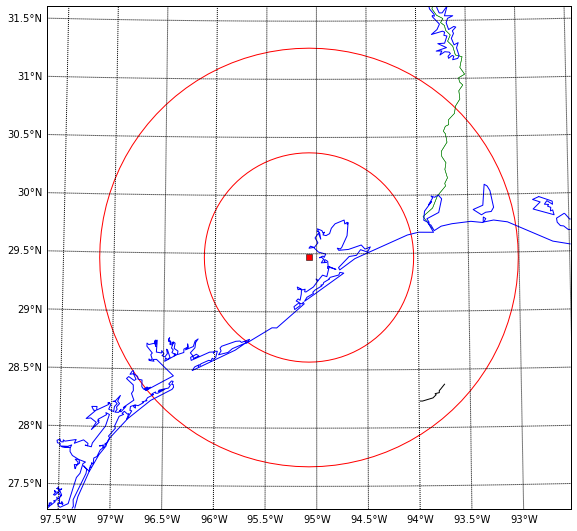

In [400]:
#print t1.x[t1.particle==20].as_matrix
xii = (np.around(t1.x[t1.particle==20].values)).astype(int)
yii = (np.around(t1.y[t1.particle==20].values)).astype(int)
test1 = t1.index[t1.particle==20].values
print type(test)
print test.shape
print xii
print yii
print test1
xyii = np.vstack((xii,yii))
print xyii.shape
#..
print lat_grid.shape
lattrack = lat_grid[[yii,xii]]
lontrack = lon_grid[[yii,xii]]
print 'avg = ', np.mean(lon_grid[[yii,xii]])
print lattrack
print lontrack
#..
fig=plt.figure(figsize=(10,9))
m = Basemap(width=500000,height=480000,projection='lcc',
                resolution='i',lon_0 =radr_lon,lat_0=radr_lat,lat_1=28.,lat_2=32.)
parallels = np.arange(round(radr_lat,0)-5.,round(radr_lat,0)+5,.5)
meridians = np.arange(round(radr_lon,0)-5,round(radr_lon,0)+5,.5)
#m.bluemarble()
#m.shadedrelief()
#m.etopo()

m.tissot(radr_lon,radr_lat,108./60.,100,edgecolor='r',facecolor='none')
m.tissot(radr_lon,radr_lat,108./120.,100,edgecolor='r',facecolor='none')
m.plot(radr_lon,radr_lat,latlon=True,marker='s',color='r')
m.drawparallels(parallels,color='k',labels=[True,False,False,False])
m.drawmeridians(meridians,color='k',labels=[False,False,False,True])
m.drawstates(color='g')
m.drawcoastlines(color='b')
m.plot(lontrack,lattrack,'k',latlon=True)

#..

# JUNKY STUFF BELOW -- NONOPERATIONAL CODE STUBS!

In [ ]:
#..Saving this for later -- a progress bar!
from IPython.html.widgets import FloatProgress
from IPython.display import display
from time import sleep
f = FloatProgress(min=0, max=100)
display(f)
for i in xrange(100):
   sleep(0.1)
   f.value = i

In [ ]:
#..not sure what this does, cut from trackpy website

for pid in tr.particle.unique():
    plot(tr.x[tr.particle == pid],
                 tr.y[tr.particle == pid], 'r-')
    axis('equal'); ylim(-11, 11)

numpart = 0
partnumlist = []
for i in range(int(t1.particle.min()),int(t1.particle.max())):
    if len(t1[t1.particle==i])!=0:
        numpart += 1
        partnumlist.append(i)

In [ ]:
#..Not sure what this is from.. .cut from kdp_cell_tracker
numpart = 0
partnumlist = []
for i in range(int(t1.particle.min()),int(t1.particle.max())):
    if len(t1[t1.particle==i])!=0:
        numpart += 1
        partnumlist.append(i)